In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

import scanpy as sc

from sciso.plot import *

Set plot style

In [2]:
set_nature_style()

## Set paths

In [3]:
# Input
data_dir = Path(r"/media/buglakova/Extreme SSD/isotope_tracing_backup/data/share/20220411_AB_DKFZACLYac") 
anndata_dir = data_dir / "anndata"
adata_path = anndata_dir / "aclykd_adata_concat_filtered.h5ad"
adata_am_path =anndata_dir / "aclykd_adata_am_concat.h5ad"

# Output
plots_path = data_dir / "assign_conditions_plots"
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

## Load anndata

In [4]:
adata = sc.read_h5ad(adata_path)

In [5]:
print("All ions:")
print(adata.var.unlabeled_annotation_id.unique())

All ions:
['C18H36O2-H', 'C18H34O2-H', 'C16H32O2-H', 'C16H30O2-H', 'C14H28O2-H']
Categories (5, object): ['C18H36O2-H', 'C18H34O2-H', 'C16H32O2-H', 'C16H30O2-H', 'C14H28O2-H']


## Plot separate measurements

In [6]:
def min_square(p, iso_even):
    n = iso_even.shape[0]
    x = np.arange(0, n)
    density = binom.pmf(x, n, p)
    return np.sum(np.square(iso_even - density))


def fit_binomial(iso_dist):
    iso_even = iso_dist[0::2].copy()
    iso_even[0] = 0
    iso_even /= iso_even.sum()
    n = iso_even.shape[0]
    x = np.arange(0, n)
    p_min = minimize(min_square, iso_even.argmax() / n, args=(iso_even))
    p_min = p_min.x[0]
    return x, n, p_min

# scale factor is basically labelling degree
# scale_factor = np.sum(labeled_hist[1:]) / labeled_hist.sum()
# plt.plot(df["mz"][::2], binom.pmf(x, n, p_min) * scale_factor, alpha=0.5, label='binom pmf, p=%.2f'%p_min)

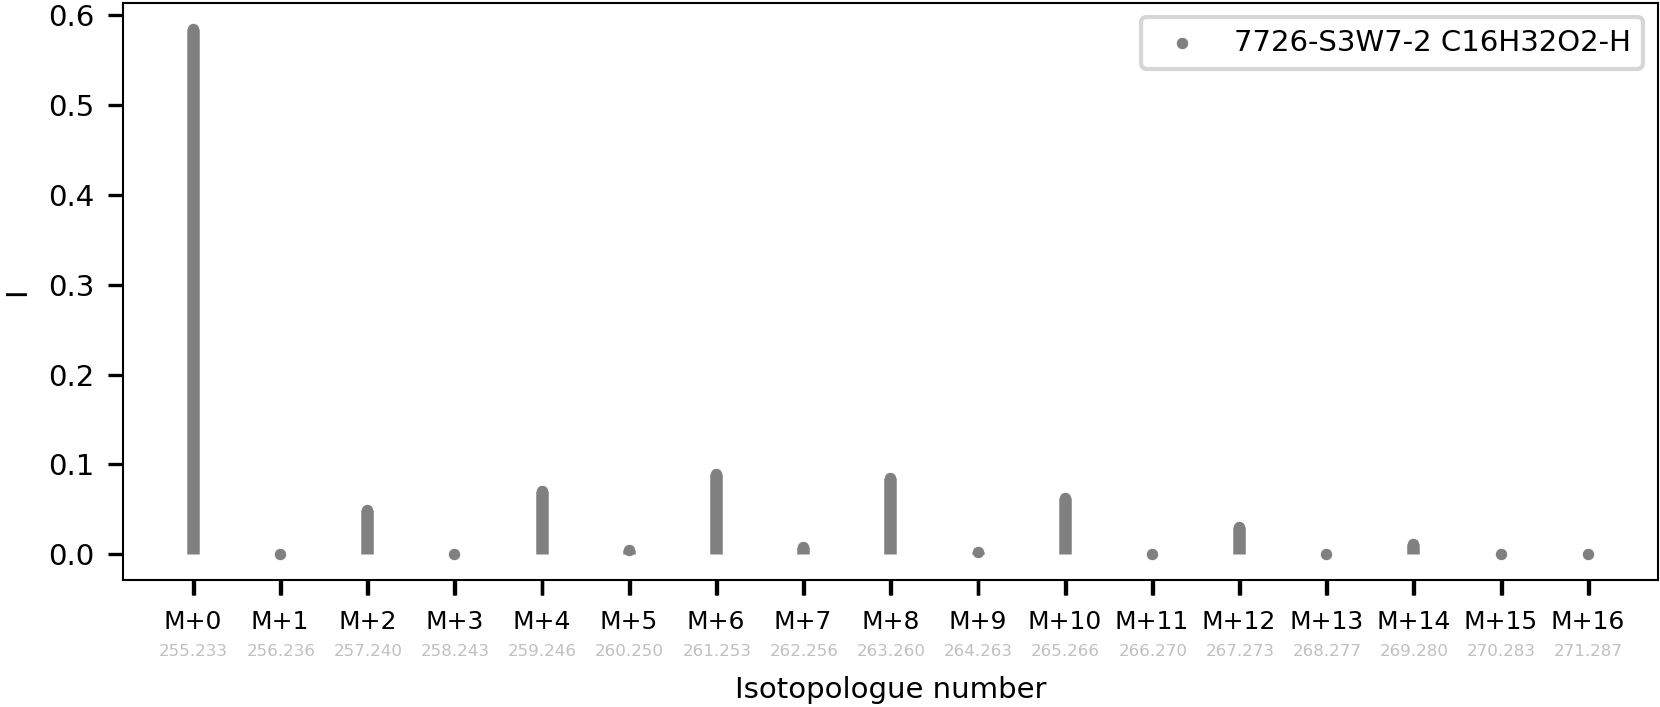

In [7]:
cell_idx = "7726-S3W7-2"
ion = 'C16H32O2-H'
layer = "corr_norm"

fig, ax = plt.subplots(1, 1, figsize=(x_width * 2, y_width))
ax = plot_iso_distribution(adata, ion, cell_idx, layer, ax=ax)

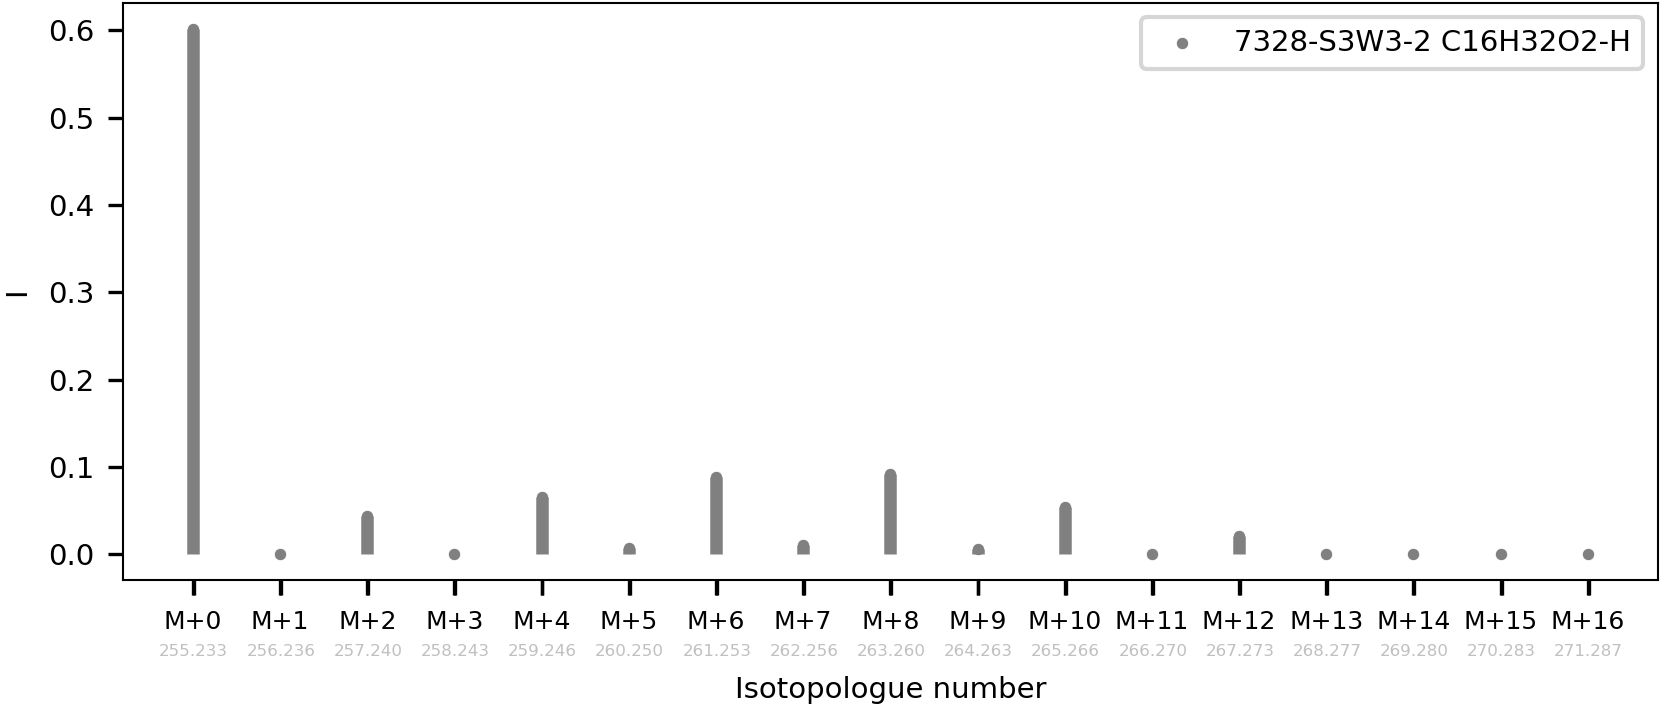

In [8]:
cell_idx = "7328-S3W3-2"
ion = 'C16H32O2-H'
layer = "corr_norm"

fig, ax = plt.subplots(1, 1, figsize=(x_width * 2, y_width))
ax = plot_iso_distribution(adata, ion, cell_idx, layer, ax=ax)

## Comparison with bulk

No bulk data yet though

In [9]:
adata.obs.condition.unique()

['ACLYkd Ol.2 + Wildtype', 'ACLYkd Ol.2', 'Wildtype', 'ACLY Ol.1 + Wildtype', 'ACLY Ol.1']
Categories (5, object): ['ACLYkd Ol.2 + Wildtype', 'ACLYkd Ol.2', 'Wildtype', 'ACLY Ol.1 + Wildtype', 'ACLY Ol.1']

In [10]:
adata.obs.growthConditions.unique()

['Labeled', 'Unlabeled']
Categories (2, object): ['Labeled', 'Unlabeled']

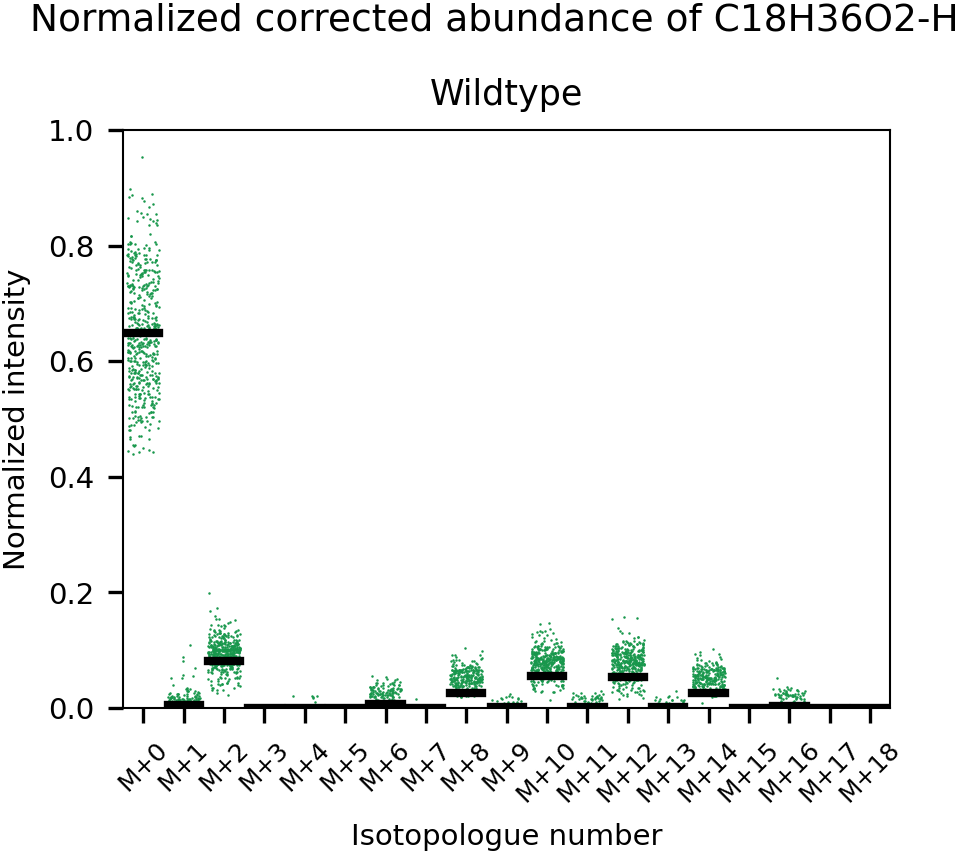

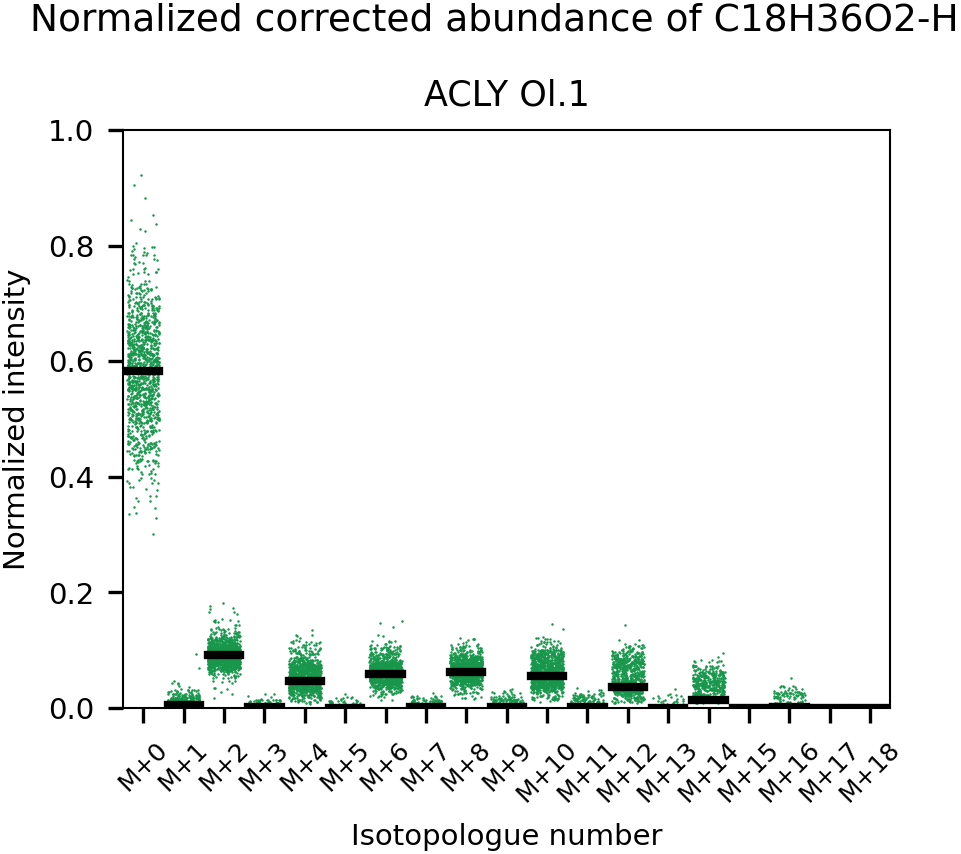

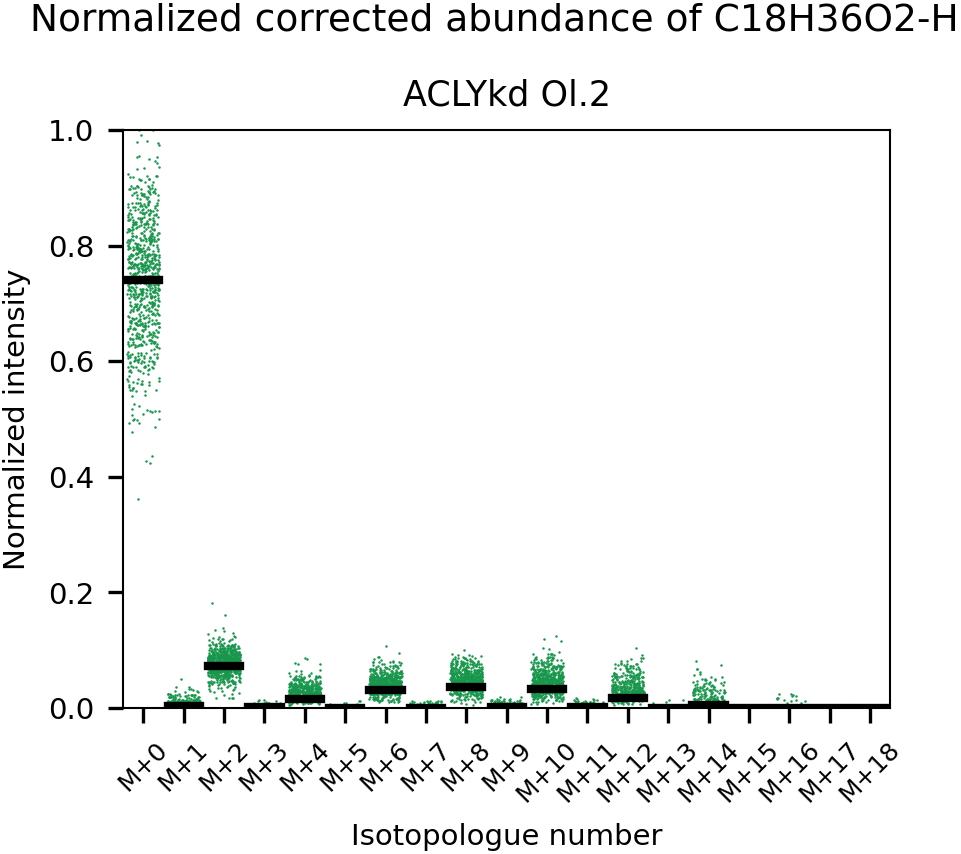

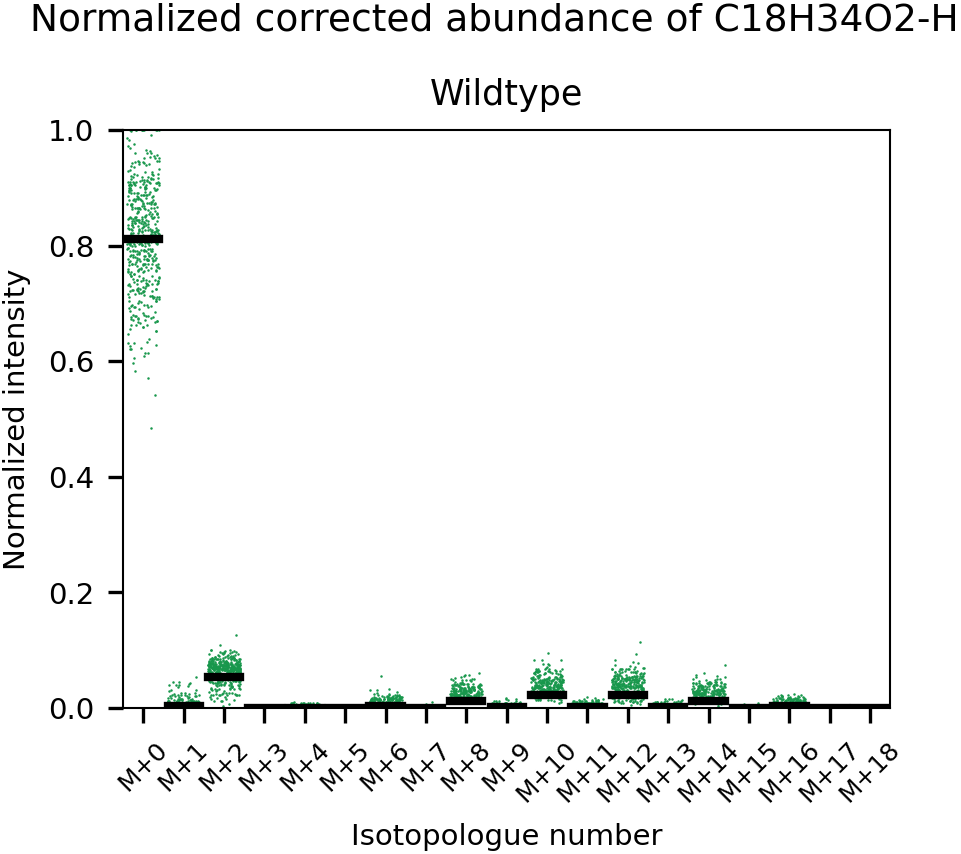

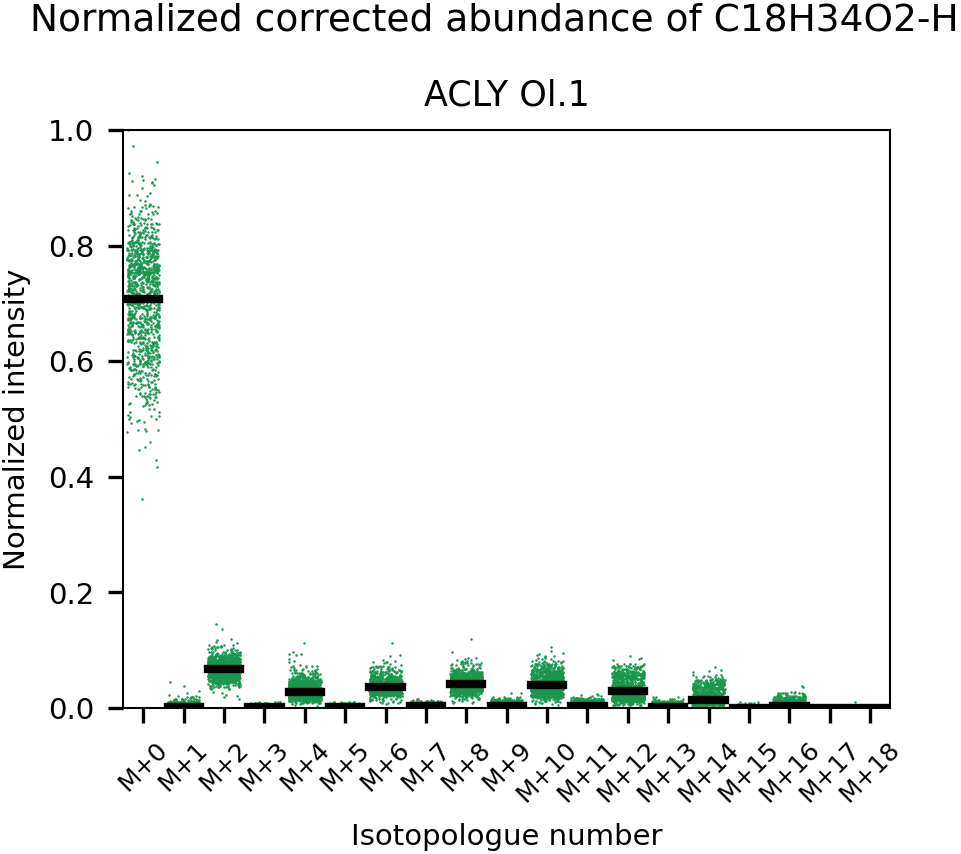

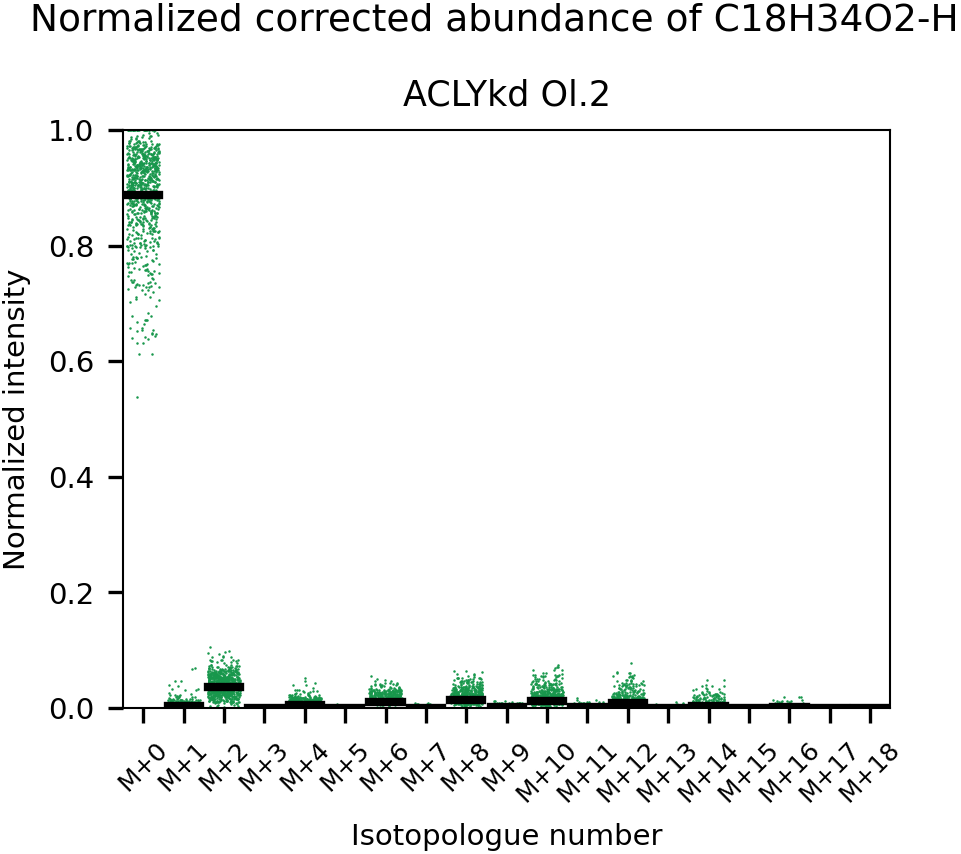

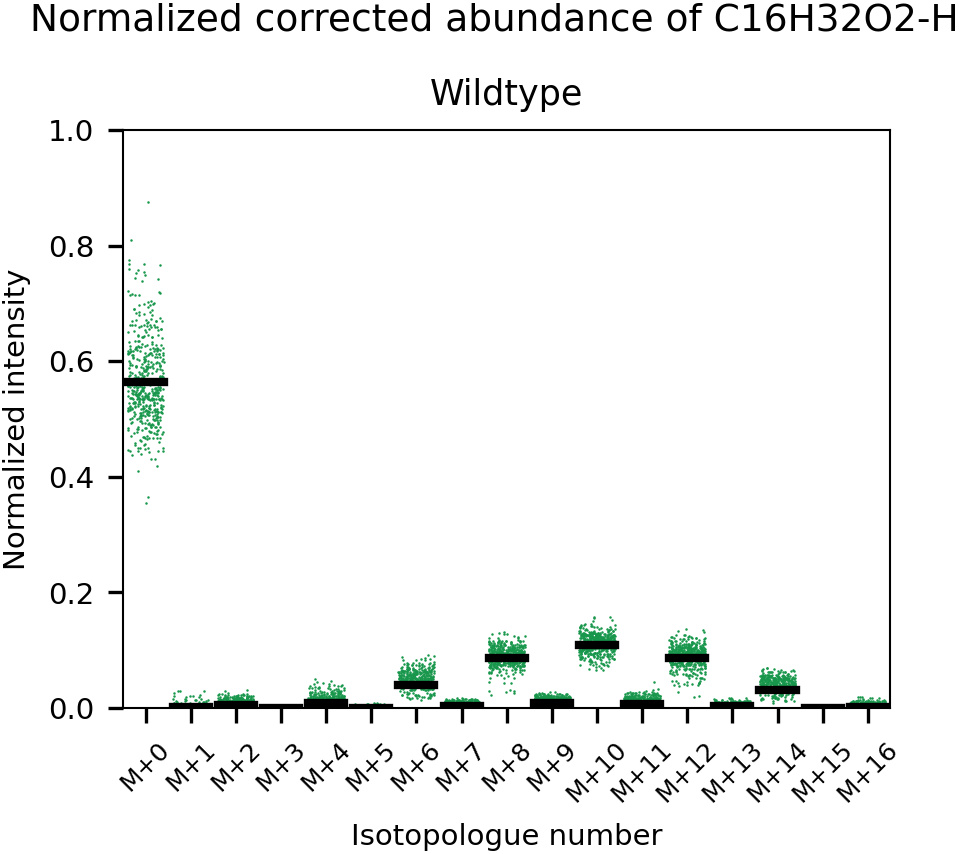

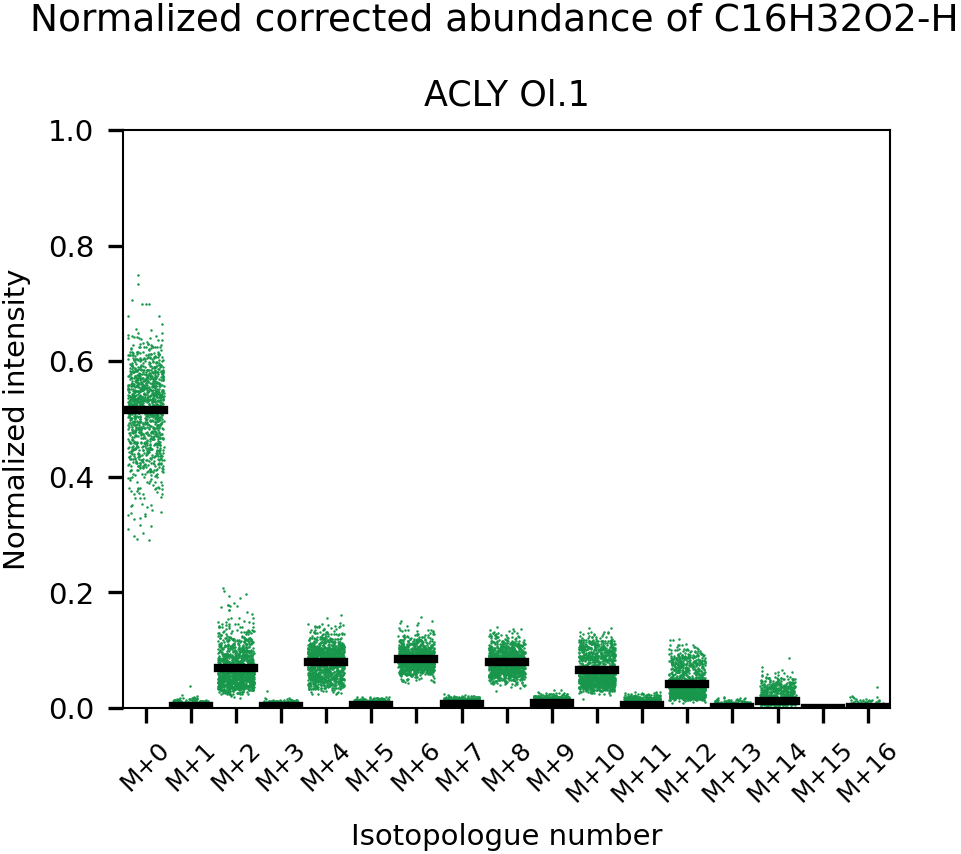

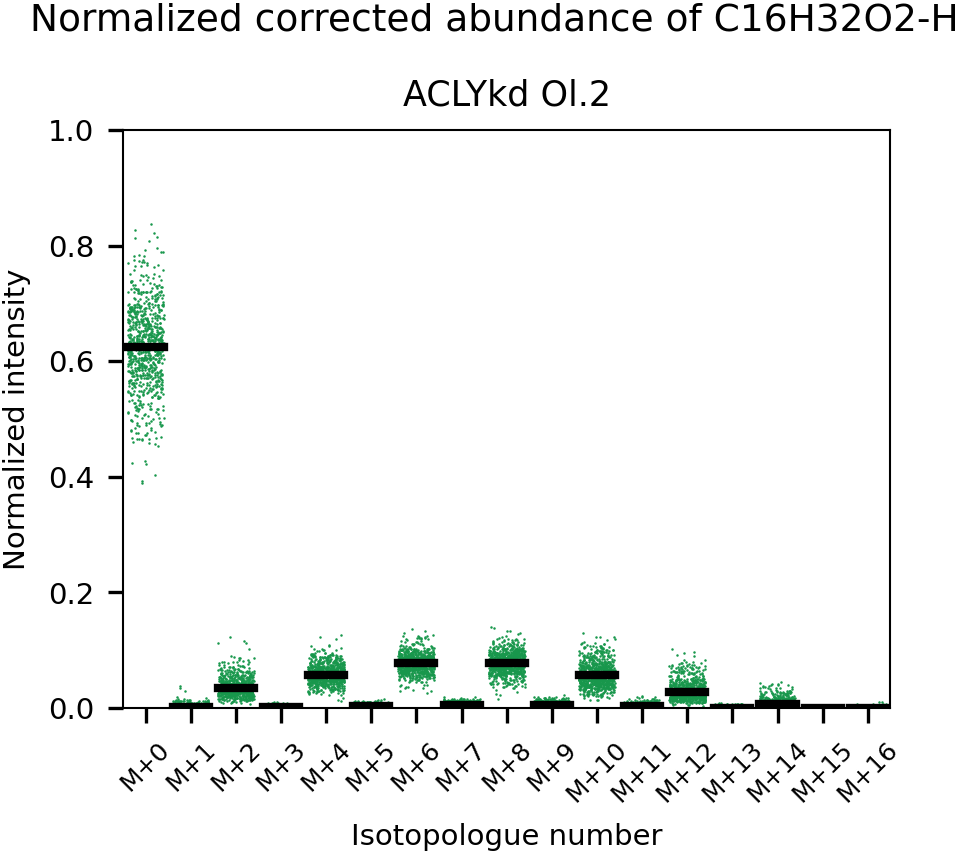

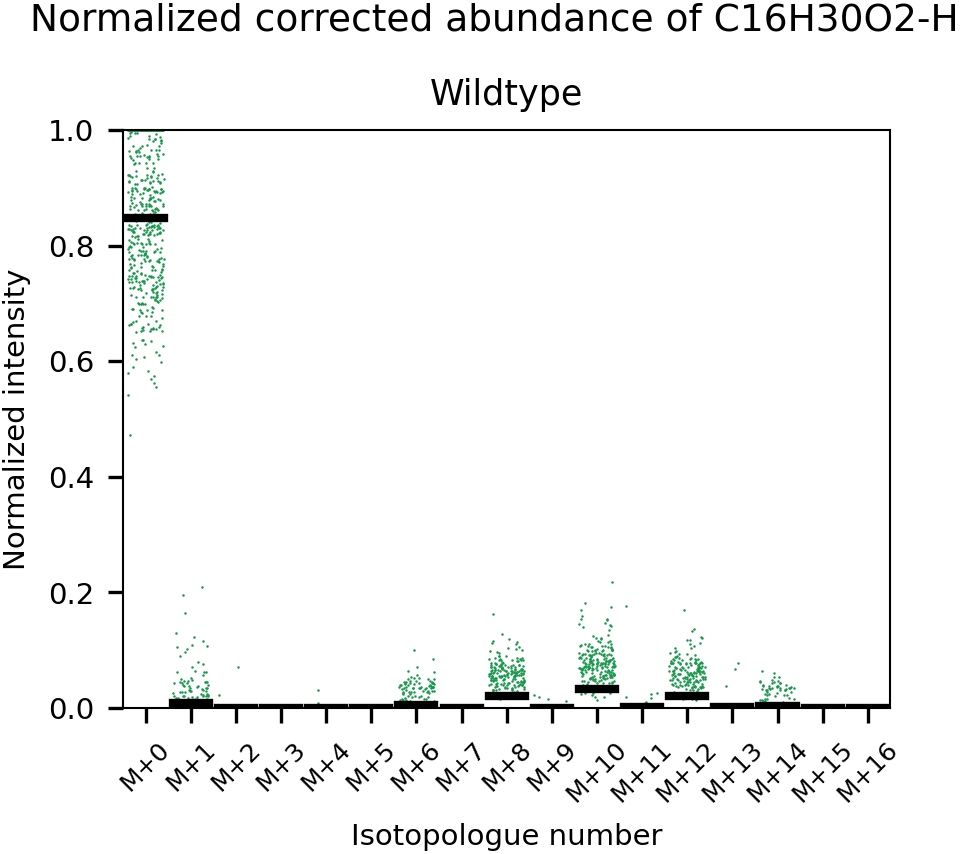

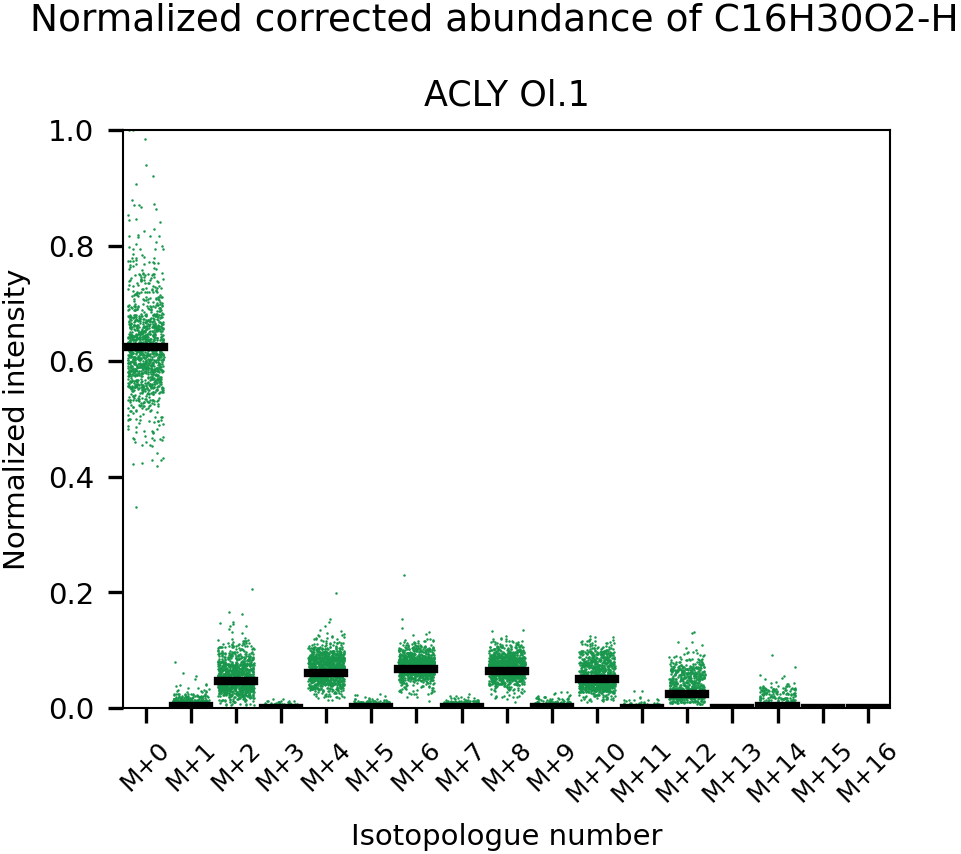

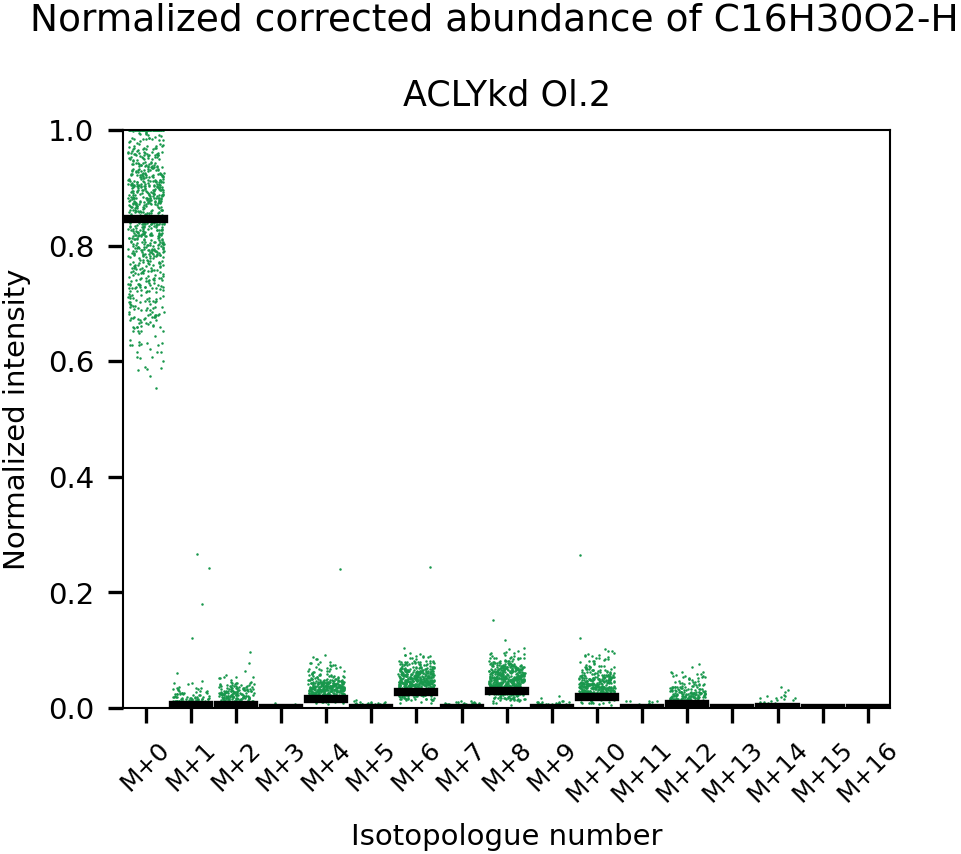

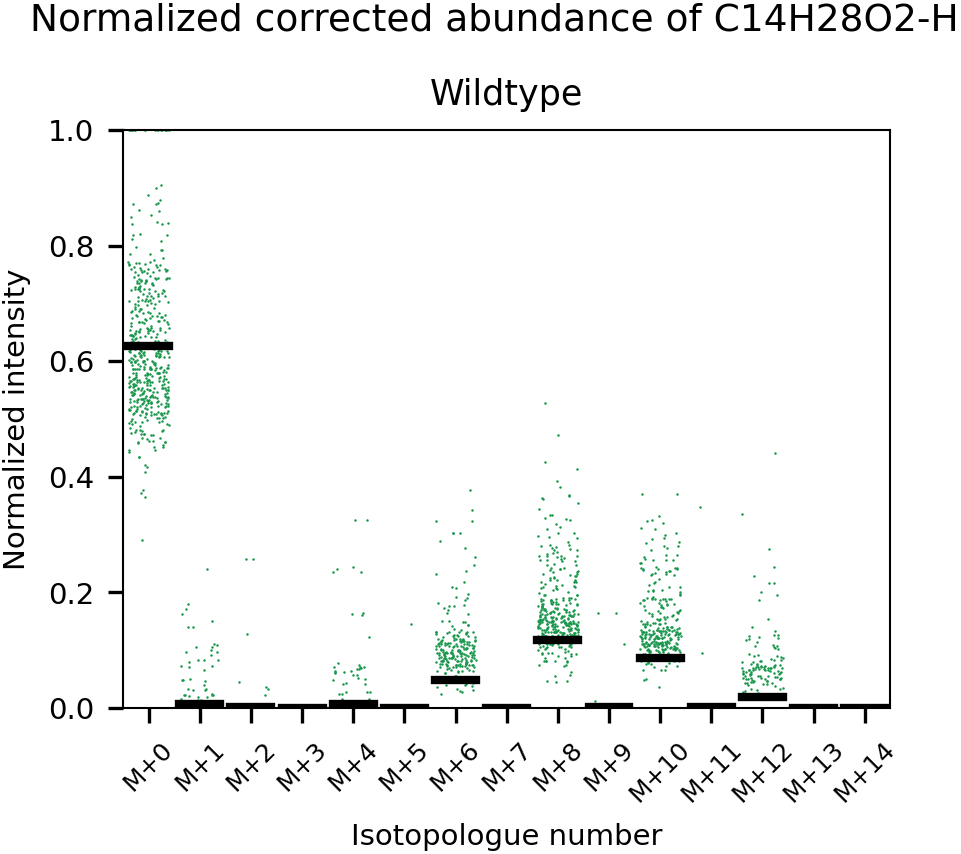

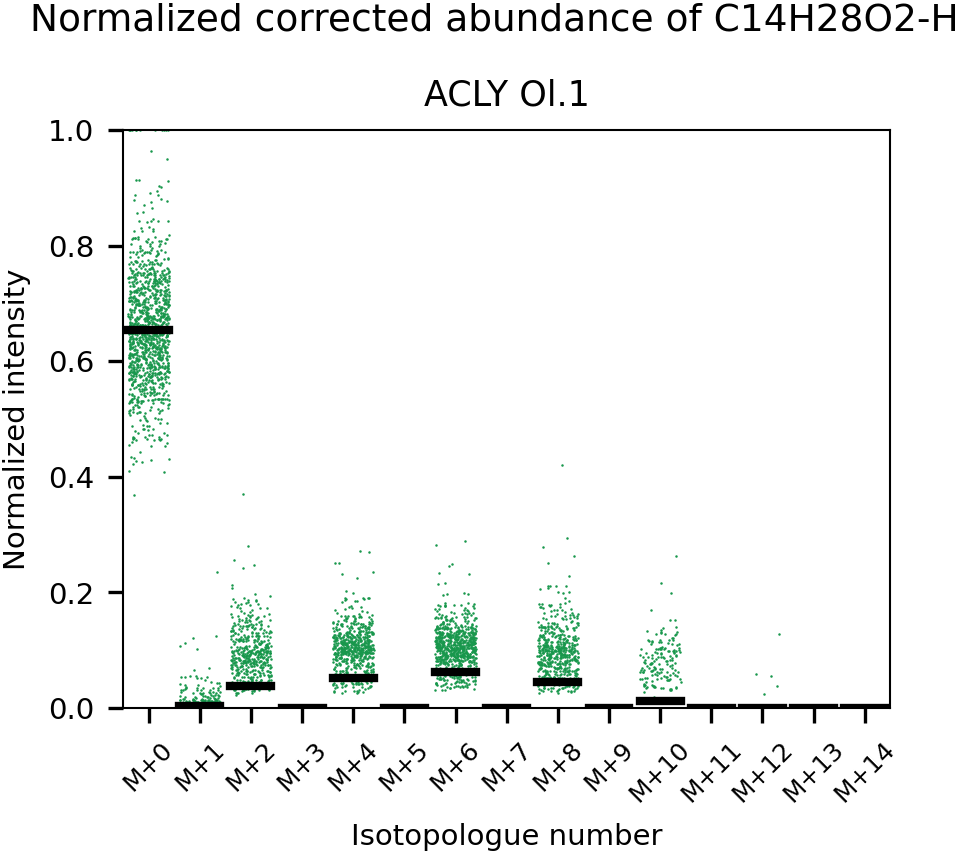

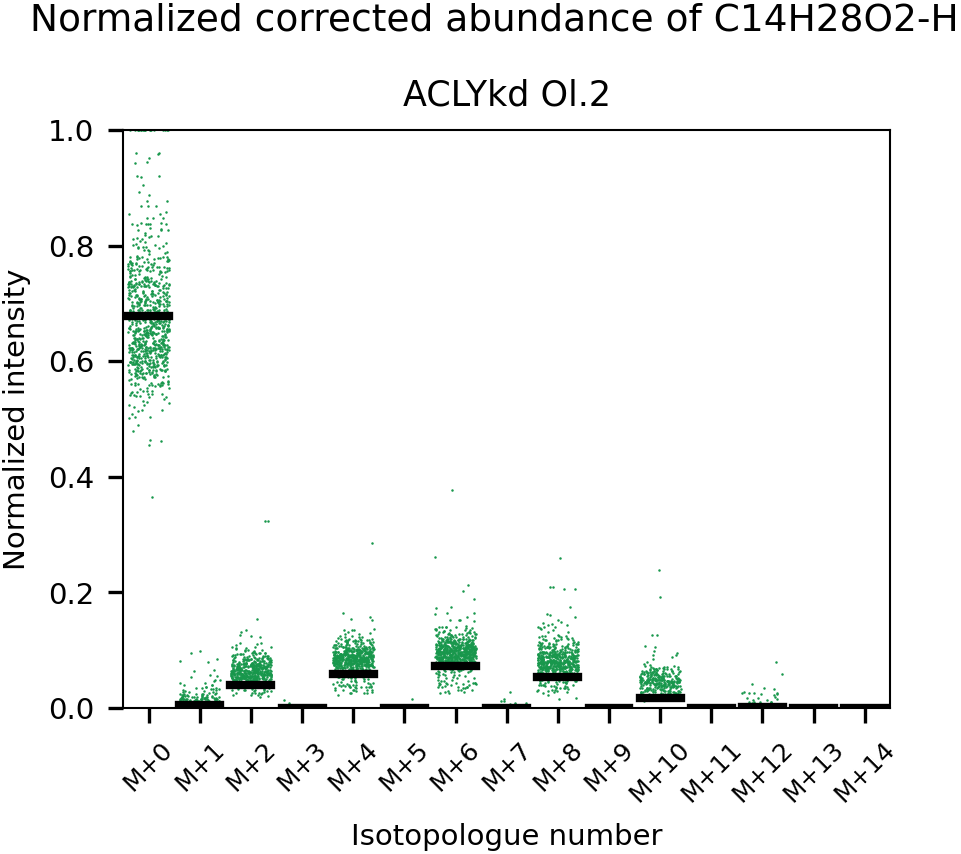

In [11]:
for idx, ion in adata.var[adata.var["M+"] == 0].iterrows():
    for cond in ['Wildtype', 'ACLY Ol.1', 'ACLYkd Ol.2']:
        adata_cond = adata[(adata.obs.condition == cond) & (adata.obs.growthConditions == "Labeled")]
        ion_stripplot_bulk(adata_cond, ion.unlabeled_annotation_id)
        plt.suptitle("Normalized corrected abundance of %s"%ion.unlabeled_annotation_id, y=1.05)
        plt.title(cond)
        plt.savefig(plots_path / ("bulk_comparison_%s_%s_labeled.png"%(cond, ion.unlabeled_annotation_id)))
        plt.savefig(plots_path / ("bulk_comparison_%s_%s_labeled.svg"%(cond, ion.unlabeled_annotation_id)))
        plt.show()

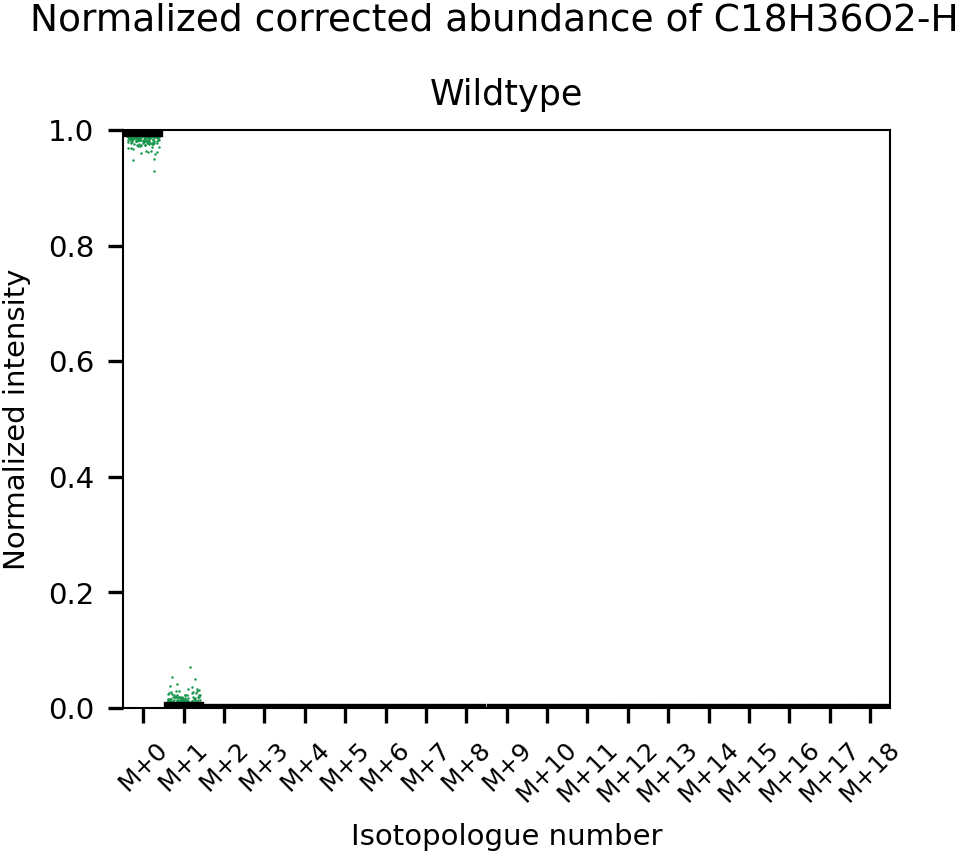

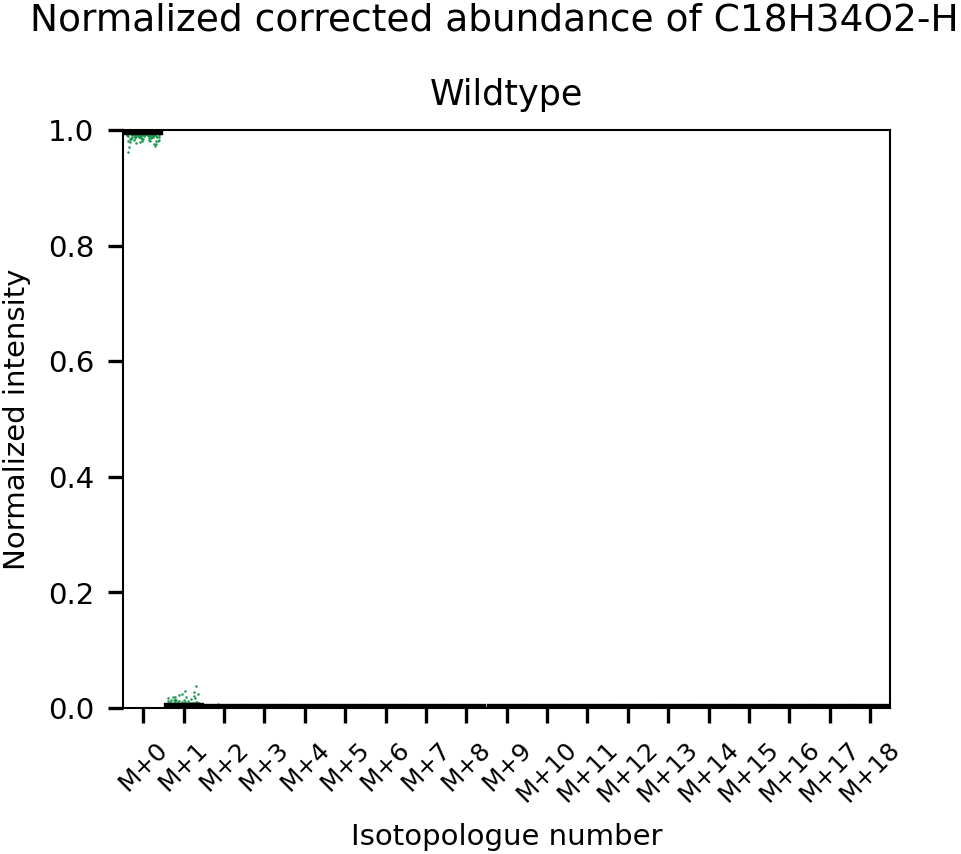

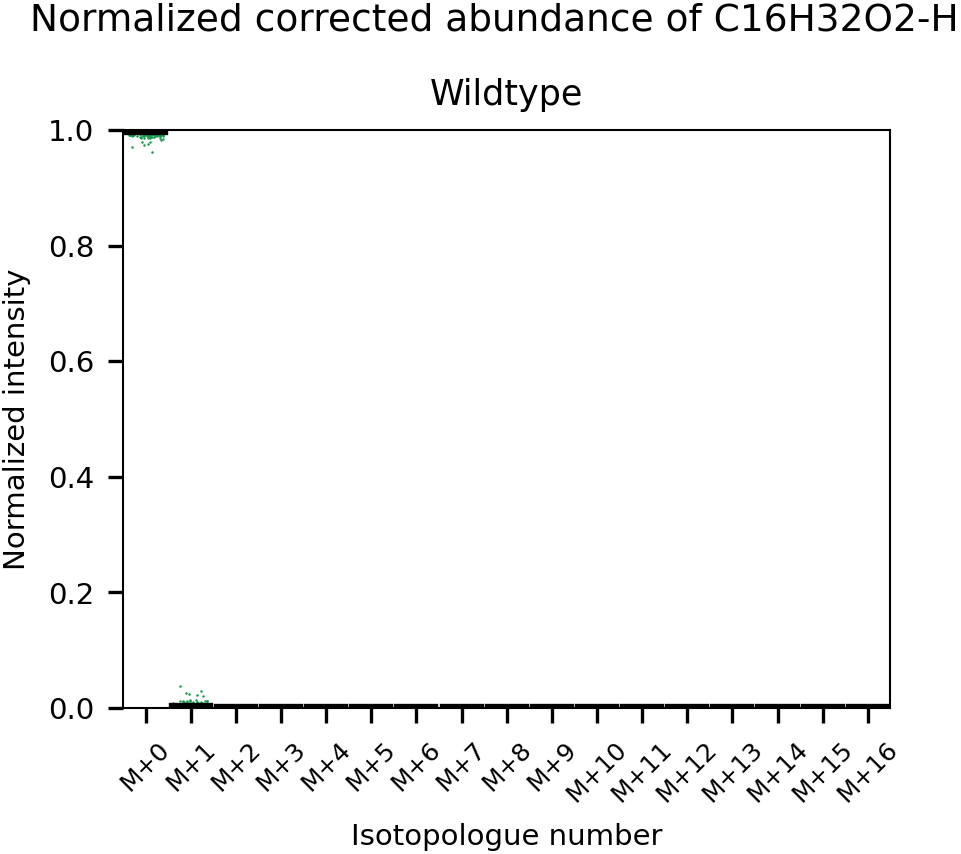

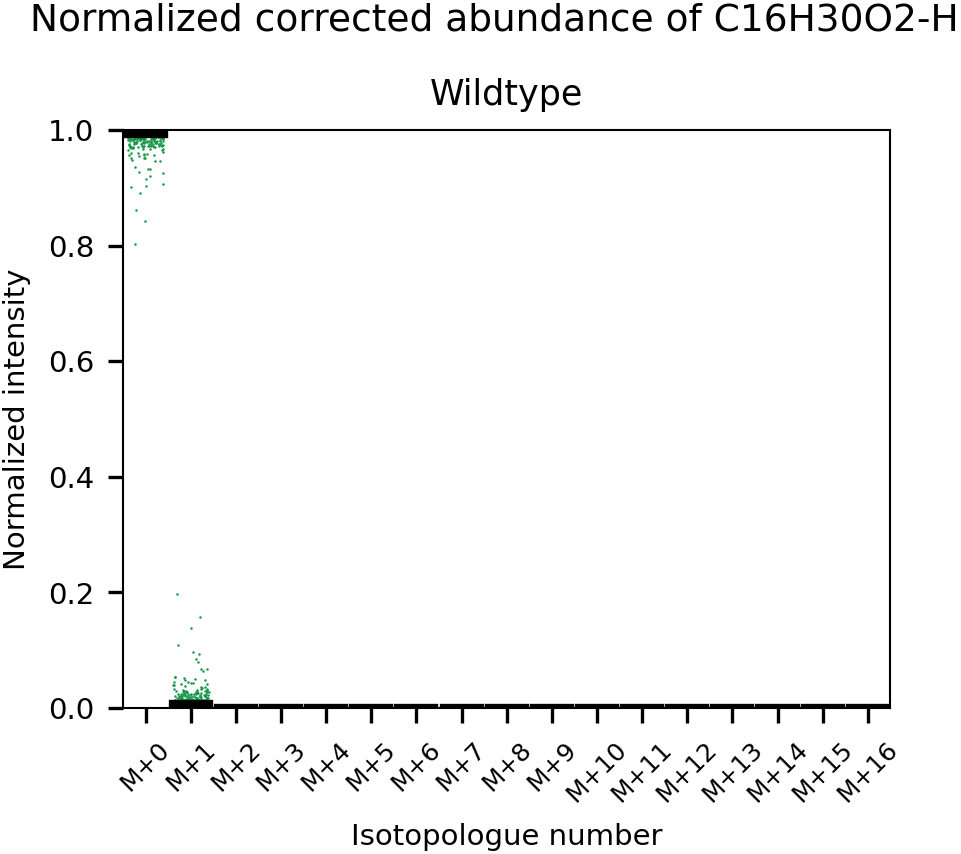

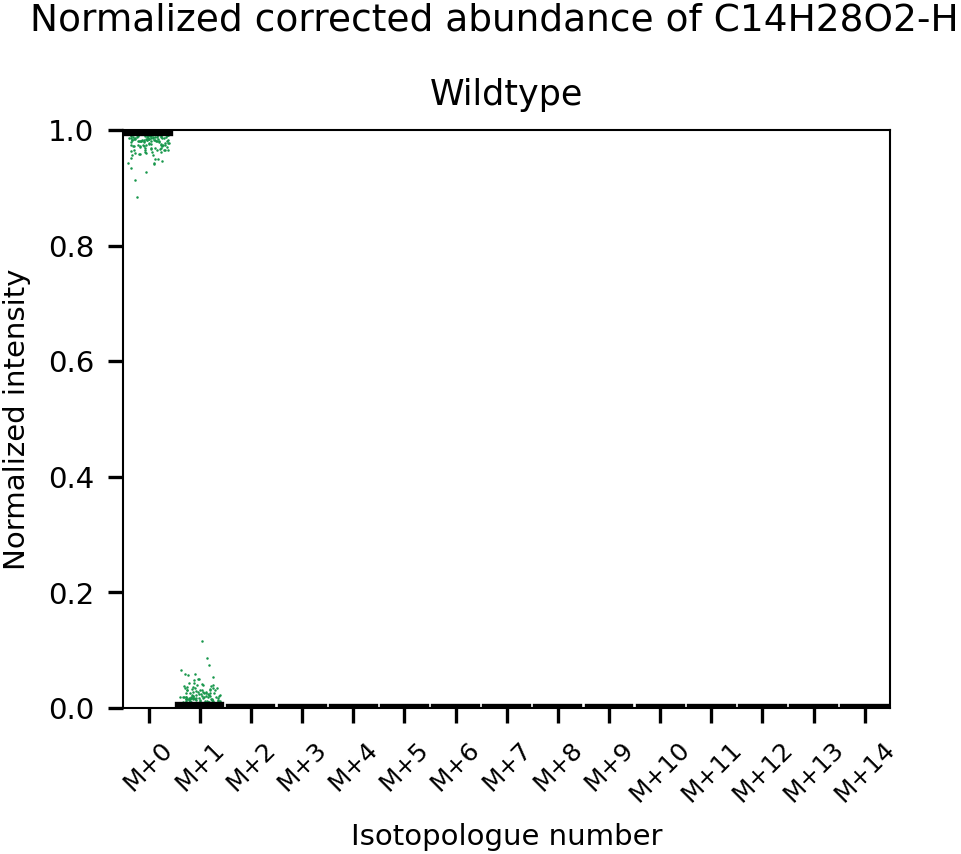

In [12]:
for idx, ion in adata.var[adata.var["M+"] == 0].iterrows():
    for cond in ['Wildtype', 'ACLY Ol.1', 'ACLYkd Ol.2']:
        adata_cond = adata[(adata.obs.condition == cond) & (adata.obs.growthConditions == "Unlabeled")]
        if adata_cond.shape[0] > 0:
            ion_stripplot_bulk(adata_cond, ion.unlabeled_annotation_id)
            plt.suptitle("Normalized corrected abundance of %s"%ion.unlabeled_annotation_id, y=1.05)
            plt.title(cond)
            plt.savefig(plots_path / ("bulk_comparison_%s_%s_unlabeled.png"%(cond, ion.unlabeled_annotation_id)))
            plt.savefig(plots_path / ("bulk_comparison_%s_%s_unlabeled.svg"%(cond, ion.unlabeled_annotation_id)))
            plt.show()

# Assign conditions based on fluorescence

In [13]:
def normalize(x):
    return (x - x.min())

def gfp_log(x):
    x_norm = normalize(x) 
    return np.log10(x_norm + 1)

# def gfp_log_per_batch(adata):

In [14]:
for slide in adata.obs.slide.unique():
    print("Slide: ", slide)
    slide_idx = adata[adata.obs.slide == slide, :].obs.index
    adata.obs.loc[slide_idx, "log_gfp"] = gfp_log(np.array(adata.obs.loc[slide_idx, "max_intensity-GFP"]))
    # adata.obs["median_intensity-GFP"]

Slide:  1
Slide:  2
Slide:  3


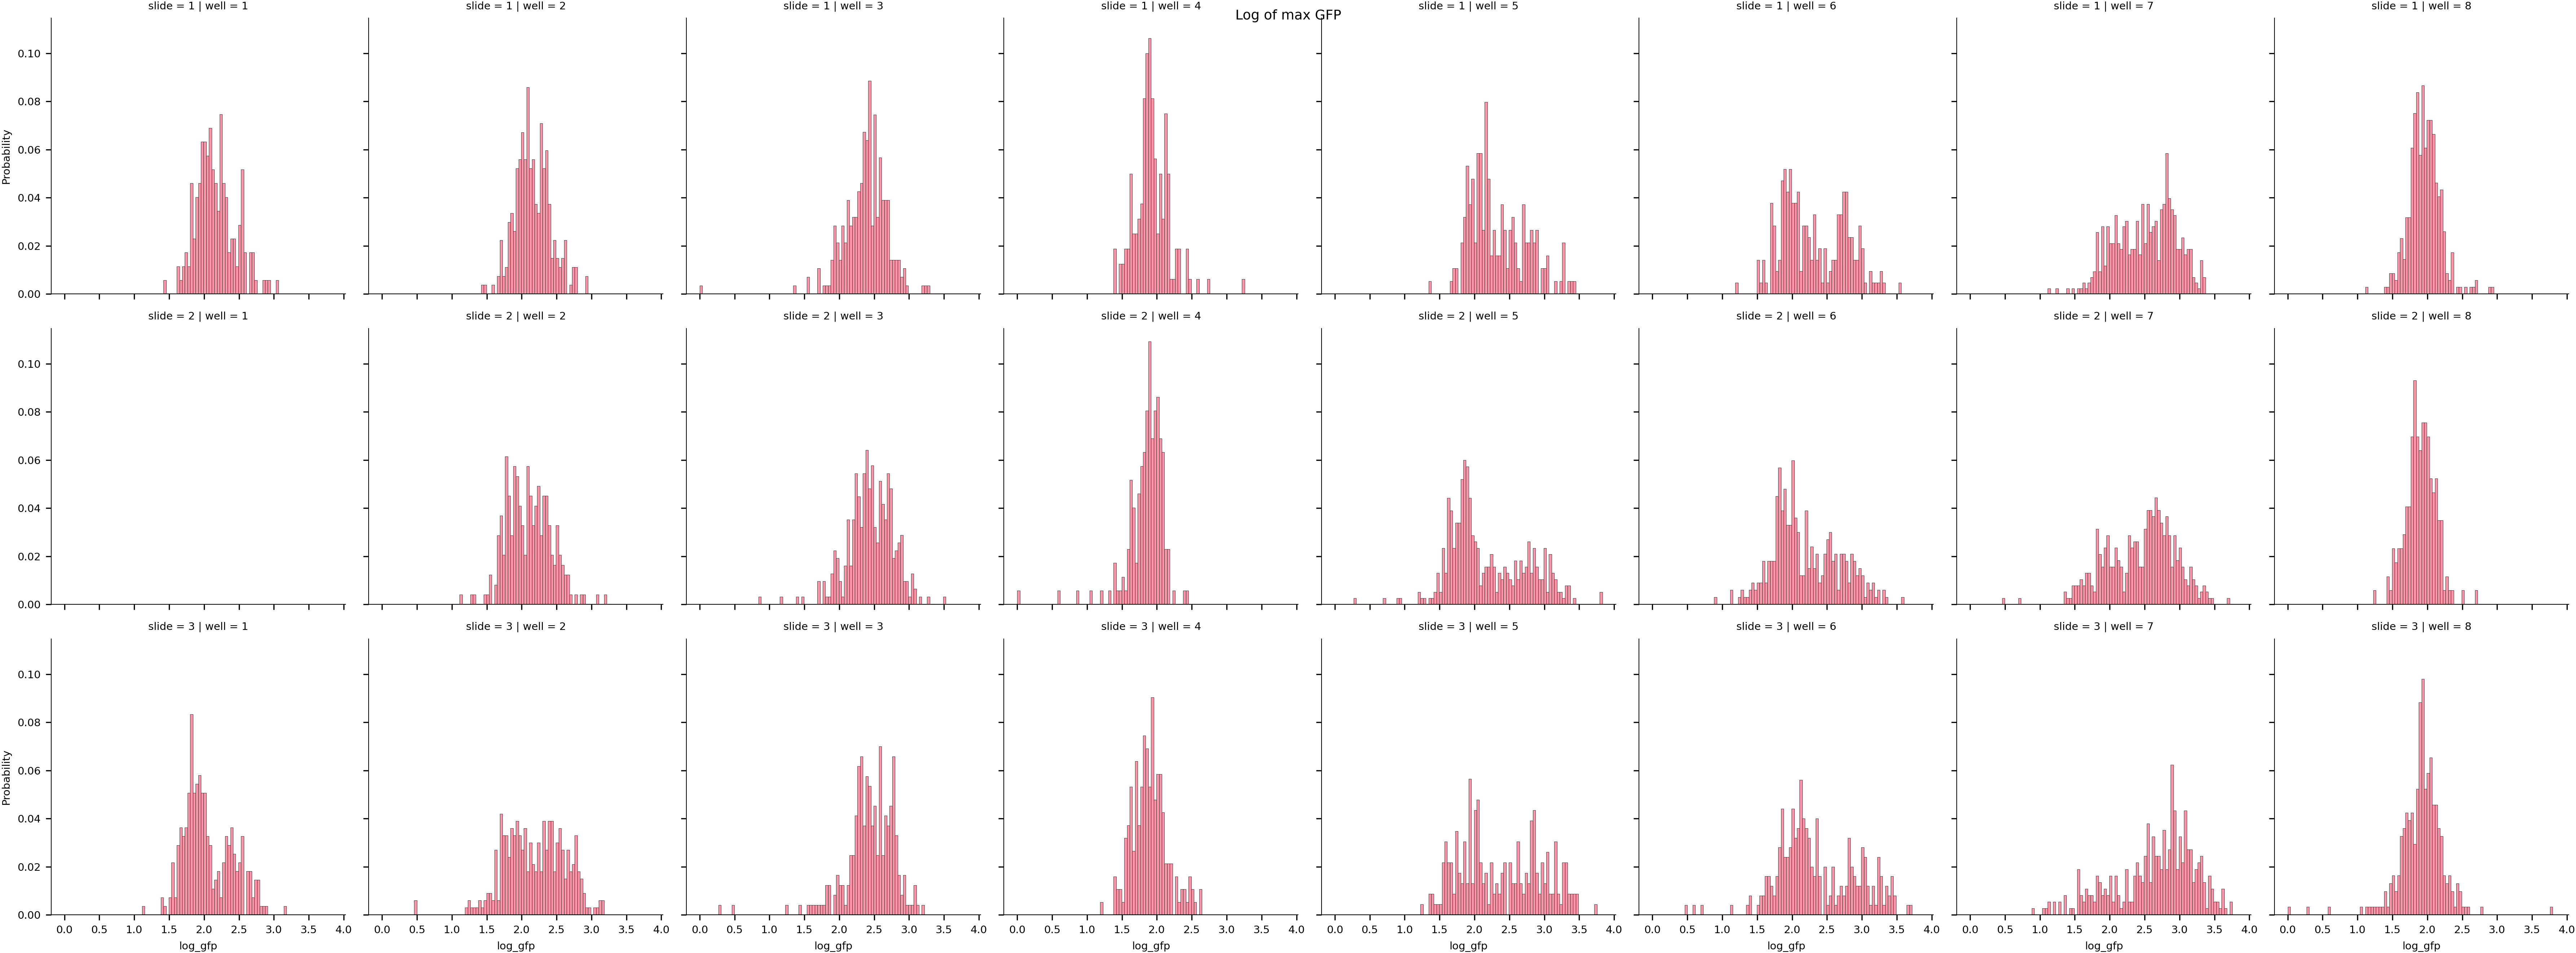

In [15]:
g = sns.FacetGrid(adata.obs, col="well",  row="slide")
g.map_dataframe(sns.histplot, x="log_gfp", stat="probability", binrange=[adata.obs.log_gfp.min(), adata.obs.log_gfp.max()], bins=100)
g.fig.suptitle("Log of max GFP")
plt.savefig(plots_path / f"hist_per_slide_log_median_gfp.png")
plt.savefig(plots_path / f"hist_per_slide_log_median_gfp.svg")
plt.show()

In [16]:
gfp_thresholds = {s: np.quantile(adata[(adata.obs.slide == s) & (adata.obs["GFP_ground_truth"] == 0), :].obs["log_gfp"], 0.95) for s in adata.obs.slide.unique()}
adata.obs["gfp_class"] = [gfp_i > gfp_thresholds[s] for gfp_i, s in zip(adata.obs.log_gfp, adata.obs.slide)]

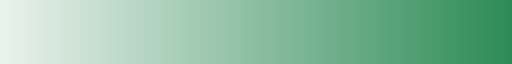

In [17]:
sns.light_palette("seagreen", as_cmap=True)

In [18]:
adata.obs["GFP state"] = adata.obs["GFP_ground_truth"].replace({0: "negative",
                                                           1: "positive",
                                                           2: "mixture"})
adata.obs["assigned GFP class"] = adata.obs["gfp_class"].replace({False: "low",
                                                           True: "high"})

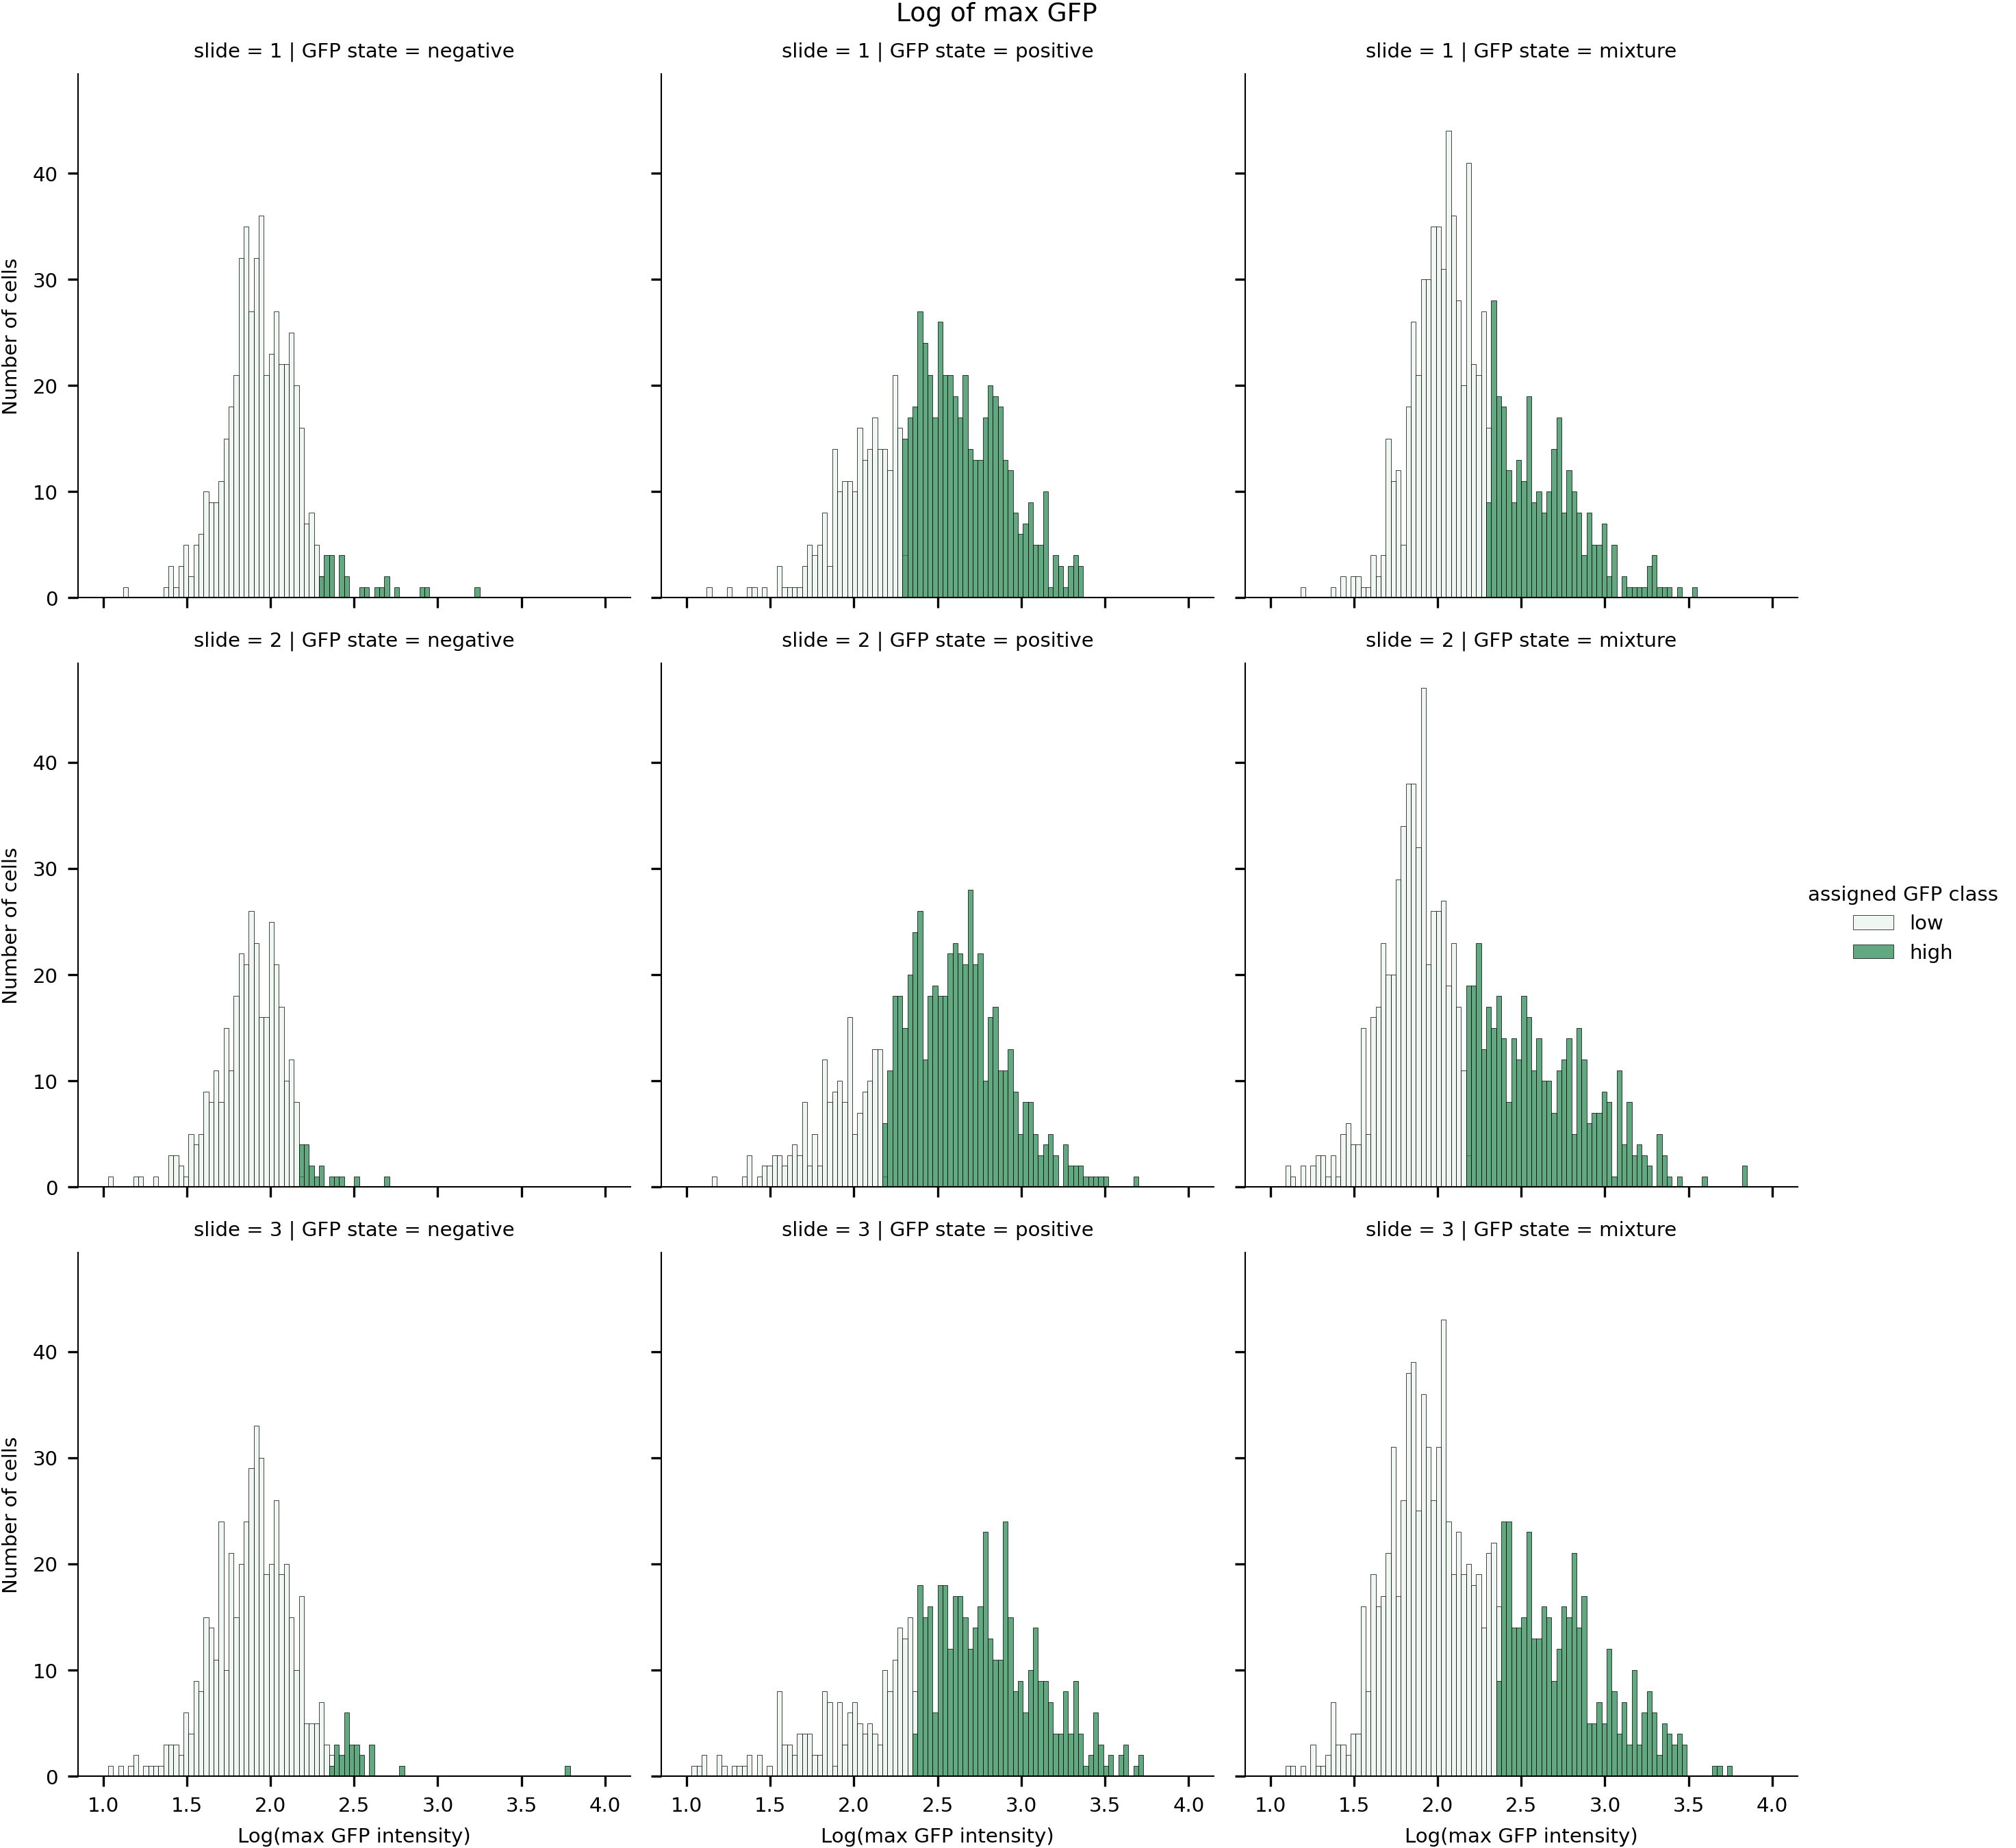

In [19]:
g = sns.FacetGrid(adata.obs, col="GFP state",
                  row="slide",
                  col_order=["negative", "positive", "mixture"],
                  hue="assigned GFP class",
                  palette=sns.light_palette("seagreen", 2),
                  hue_order=["low", "high"])
g.map_dataframe(sns.histplot, x="log_gfp", binrange=[1, 4], bins=100)
g.fig.suptitle("Log of max GFP", y=1.01)
g.add_legend()
g.set_axis_labels("Log(max GFP intensity)", "Number of cells")
plt.savefig(plots_path / f"hist_per_gfp_gt_log_max_gfp.png")
plt.savefig(plots_path / f"hist_per_gfp_gt_log_max_gfp.svg")
plt.show()

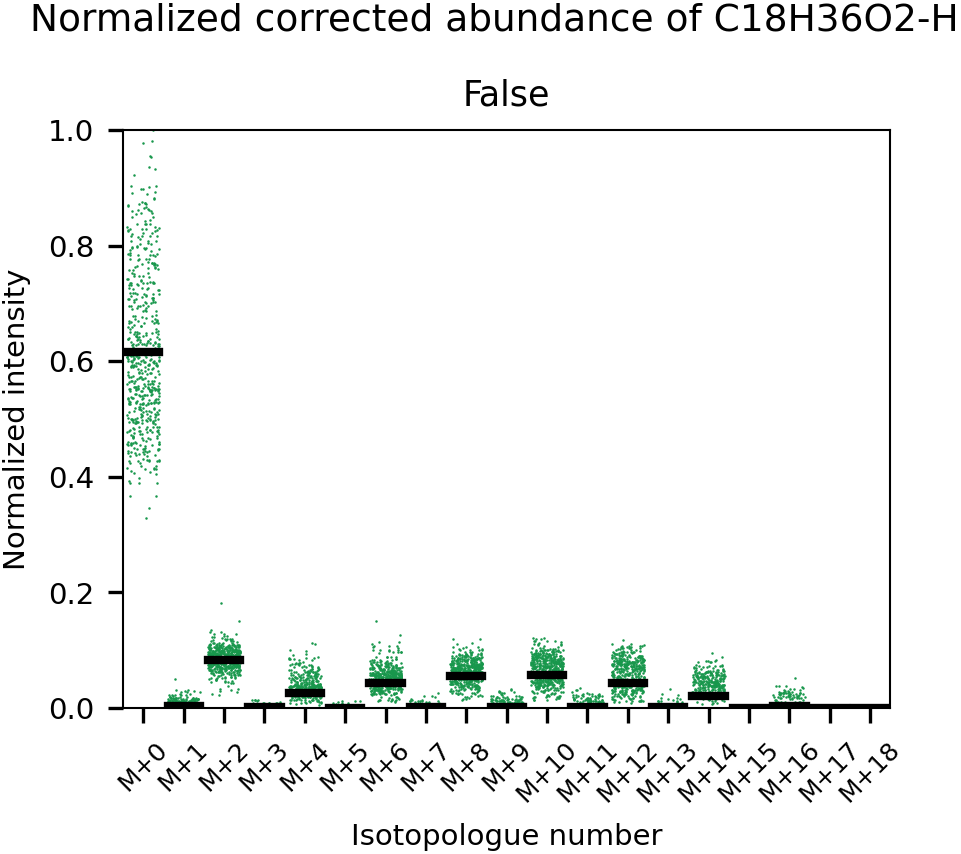

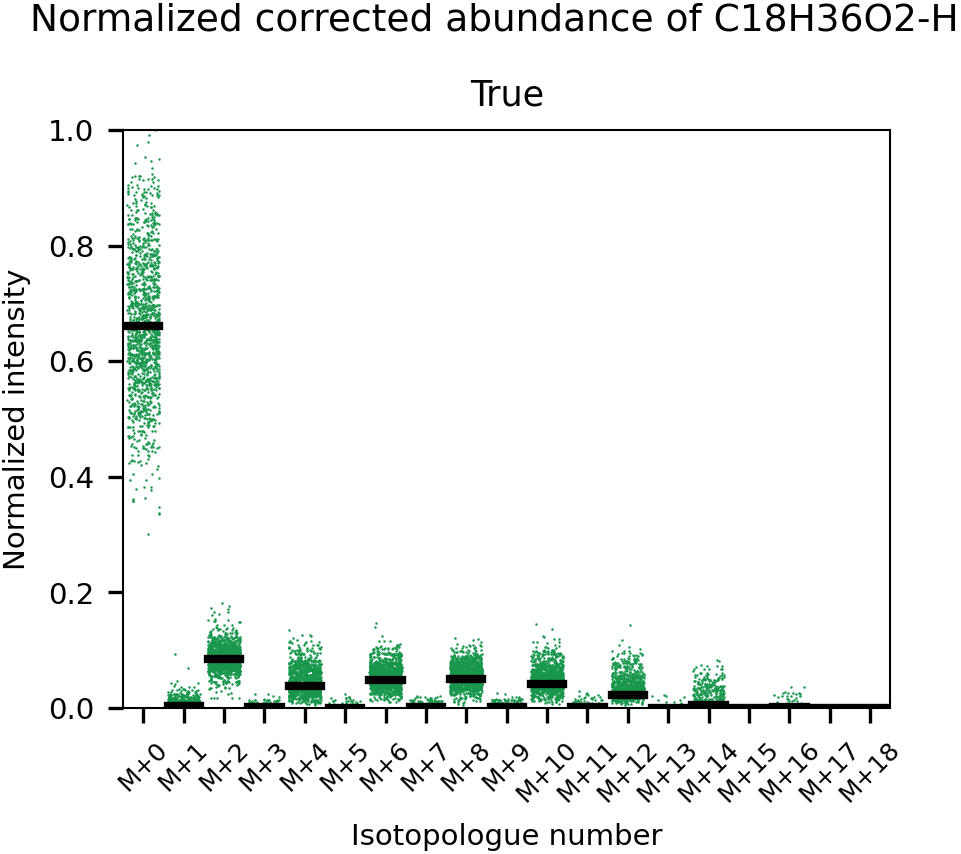

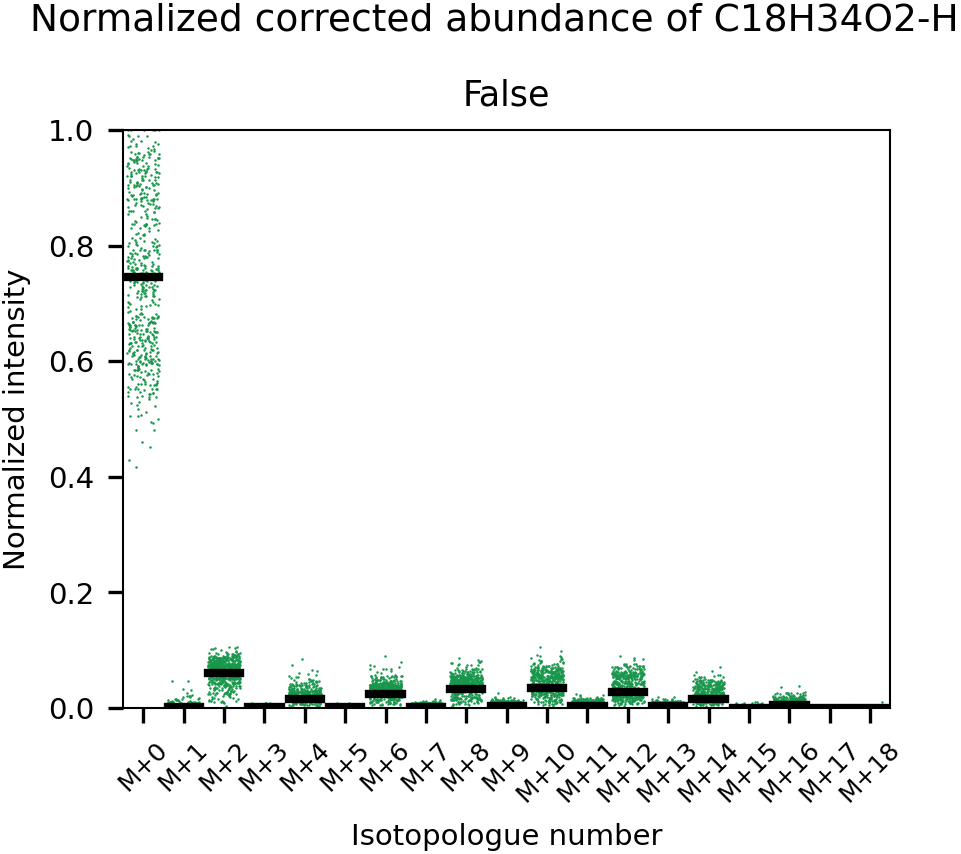

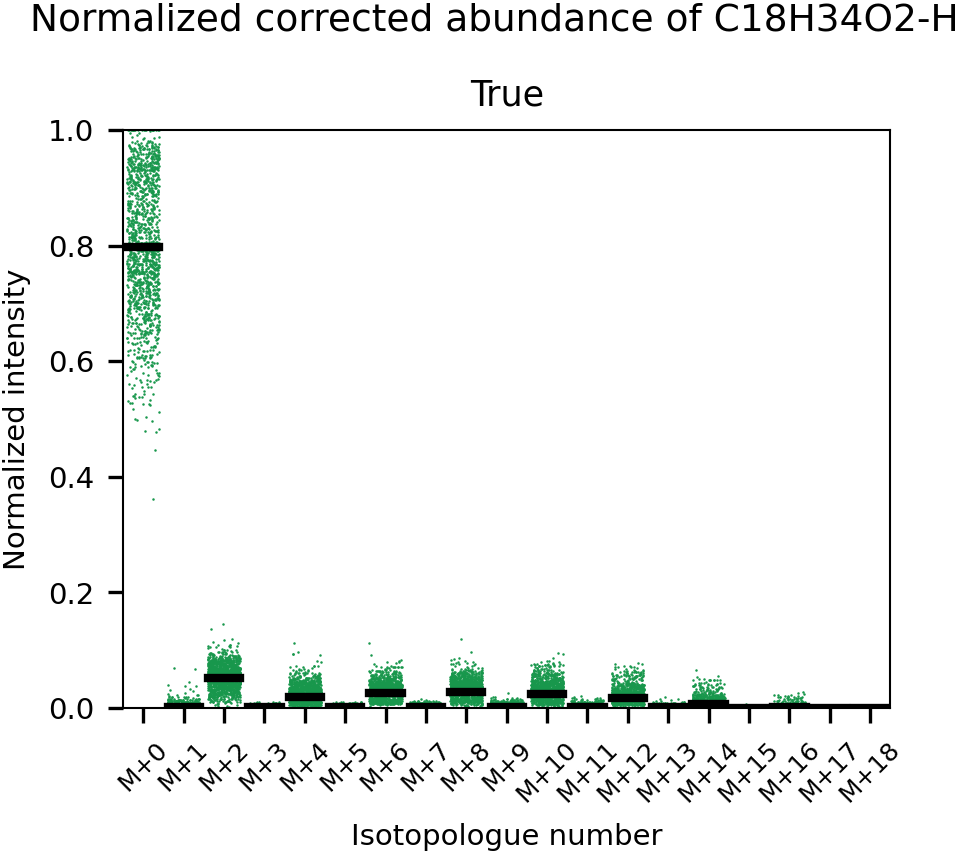

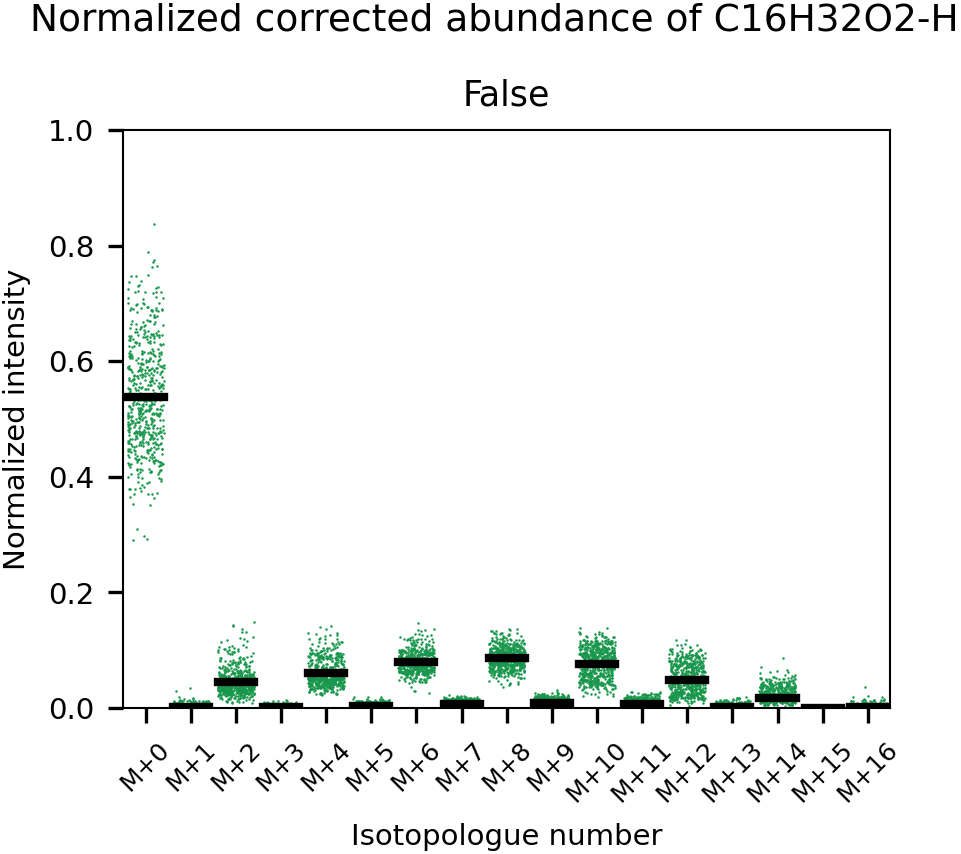

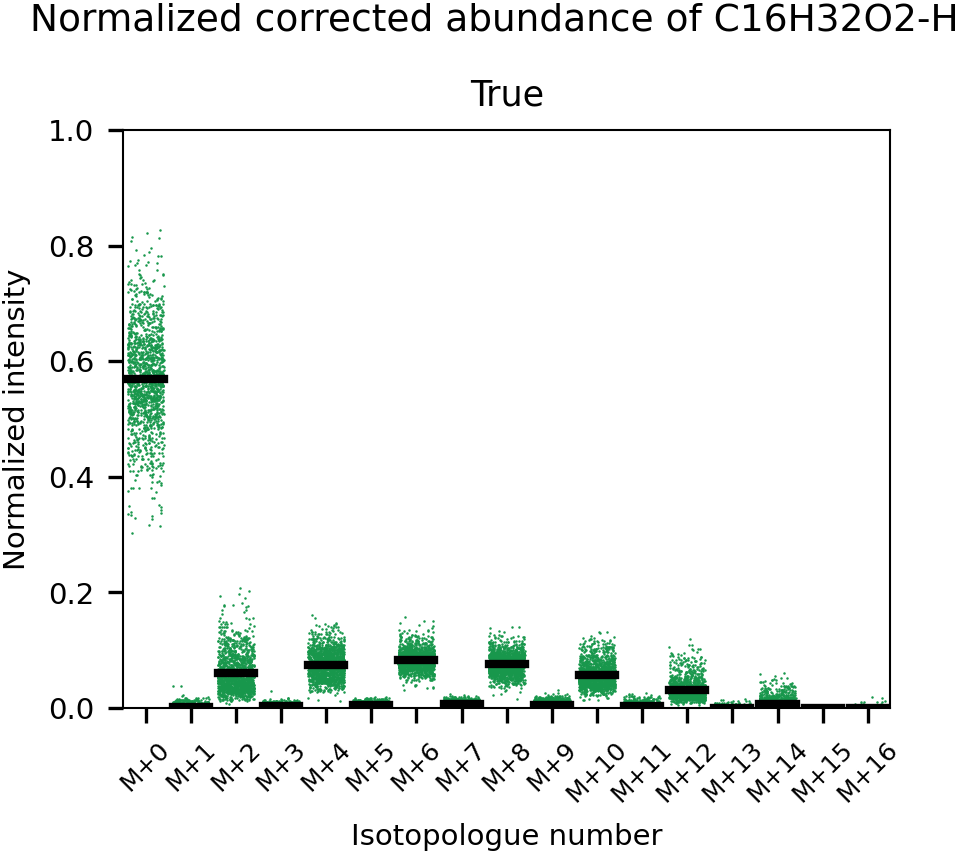

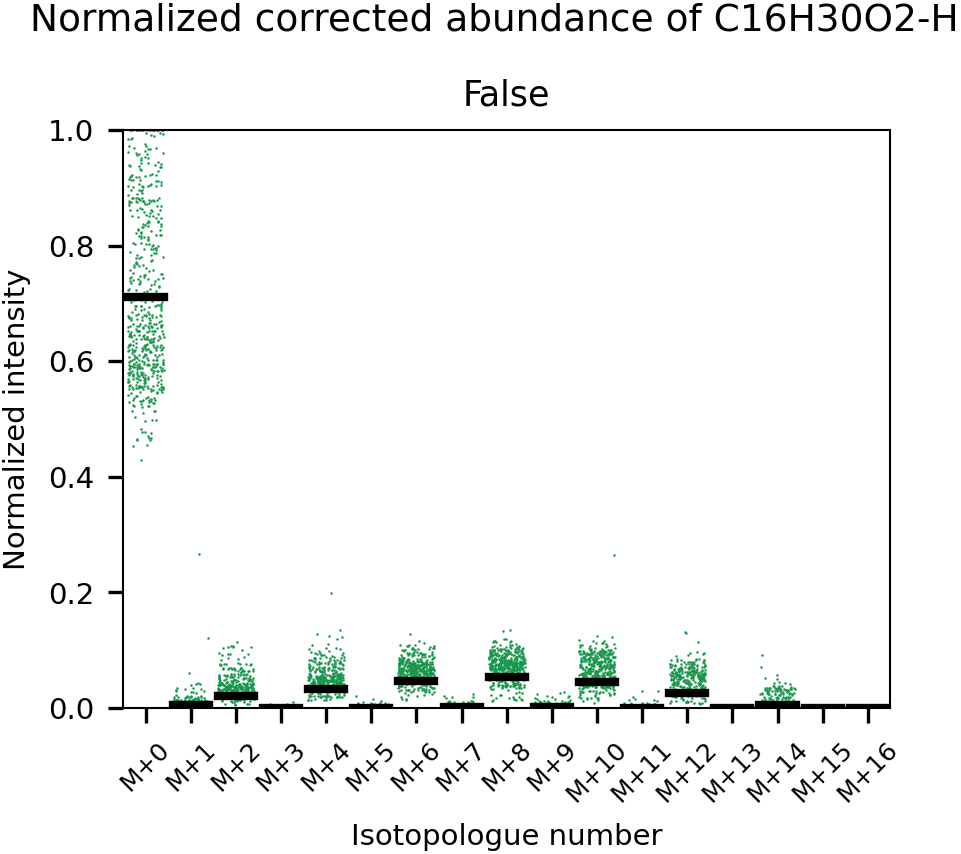

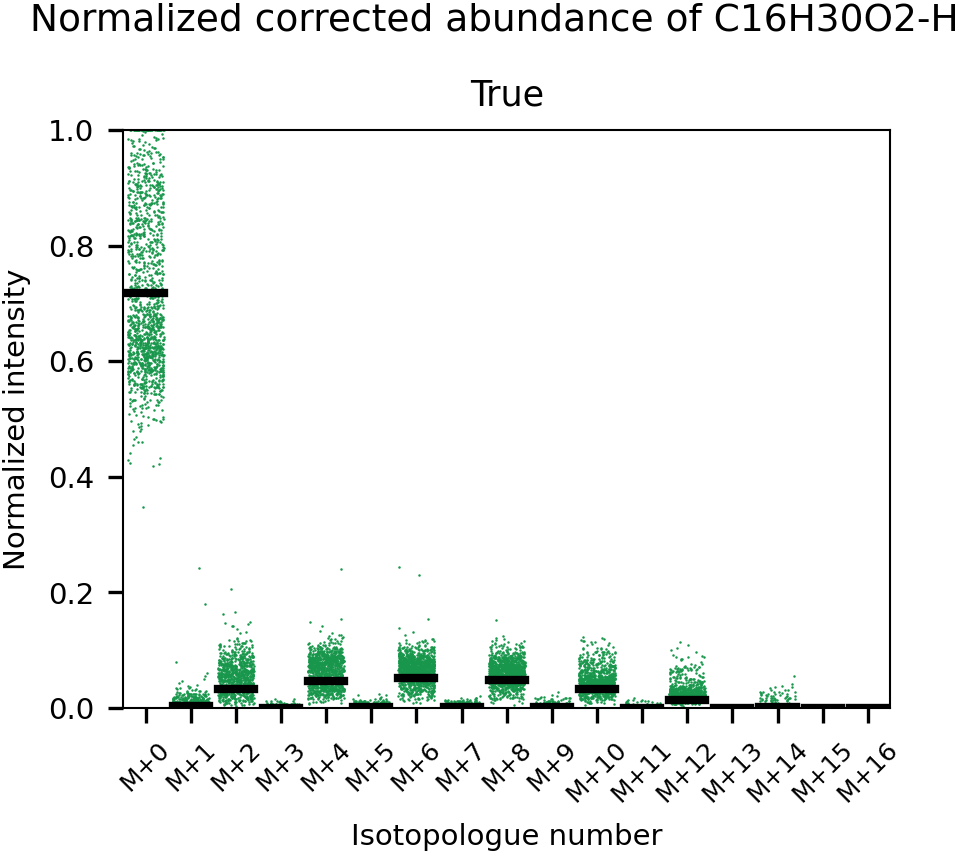

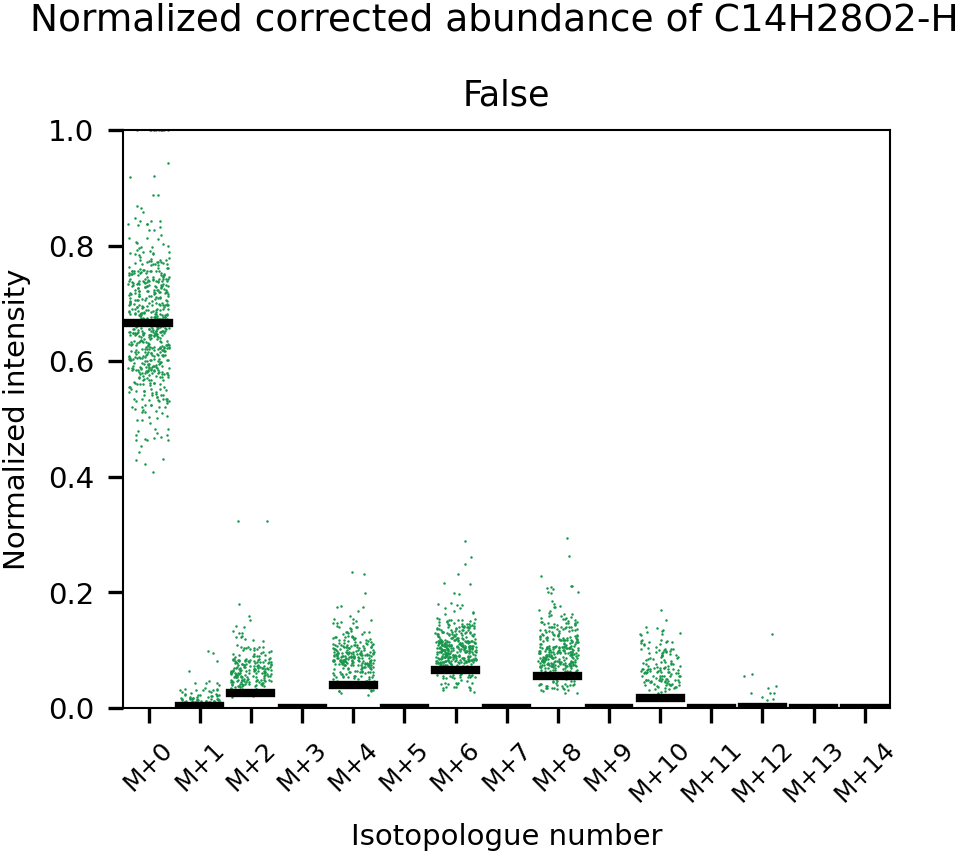

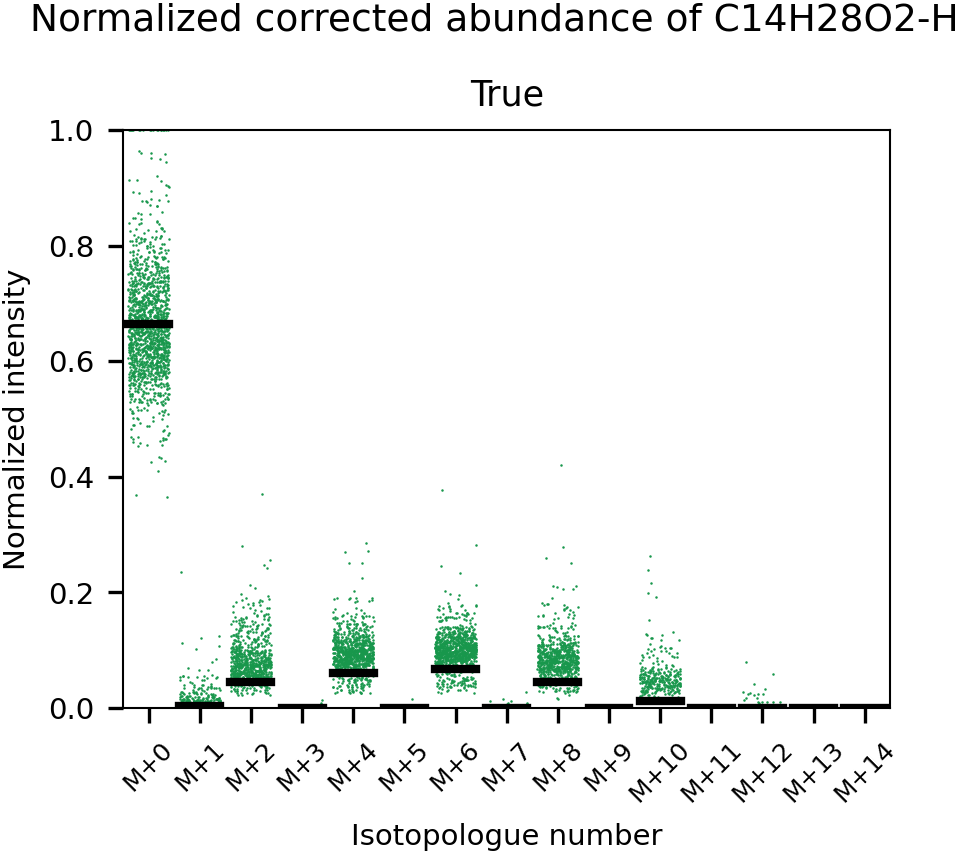

In [20]:
adata_acly = adata[adata.obs.condition.isin(['ACLY Ol.1', 'ACLYkd Ol.2'])]
for idx, ion in adata_acly.var[adata_acly.var["M+"] == 0].iterrows():
    for cond in adata_acly.obs.gfp_class.unique():
        adata_cond = adata_acly[(adata_acly.obs.gfp_class == cond) & (adata_acly.obs.growthConditions == "Labeled")]
        ion_stripplot_bulk(adata_cond, ion.unlabeled_annotation_id)
        plt.suptitle("Normalized corrected abundance of %s"%ion.unlabeled_annotation_id, y=1.05)
        plt.title(cond)
        plt.savefig(plots_path / ("bulk_comparison_%s_%s_labeled.png"%(cond, ion.unlabeled_annotation_id)))
        plt.savefig(plots_path / ("bulk_comparison_%s_%s_labeled.svg"%(cond, ion.unlabeled_annotation_id)))
        plt.show()

## Confusion matrix and classification error based on fluorescence 

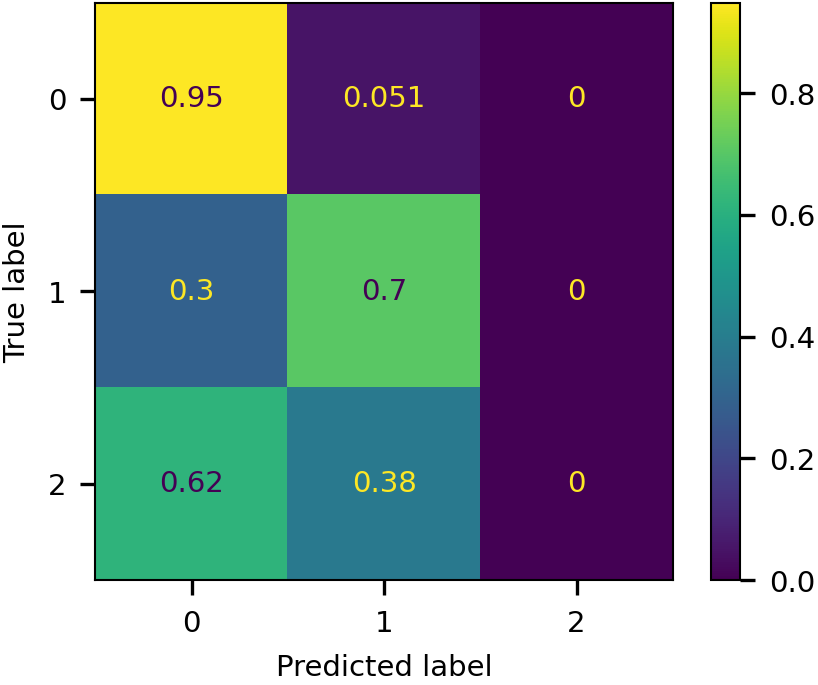

In [21]:
ConfusionMatrixDisplay.from_predictions(y_true=adata.obs["GFP_ground_truth"], y_pred=adata.obs["gfp_class"], normalize="true")
plt.savefig(plots_path / "fluorescence_confusion_matrix.png")
plt.savefig(plots_path / "fluorescence_confusion_matrix.svg")


## Save resulting Anndata

In [22]:
output_file = anndata_dir / "aclykd_adata_concat_gfp_cond.h5ad"
adata.write(output_file.with_suffix(".h5ad"))